# Linear fit of Bouguer lines on  AuxTel Data in one large wavelength bin for BG40


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : October 12th 2022
- update : October 12th 2022



** Kernel anaconda3_auxtel**




# Import

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec

%matplotlib inline
import pickle

In [2]:
import scipy.odr
import scipy.optimize

In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [4]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/57g1733im_tmg.fits',
 'comptable': '/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/5as18041m_tmc.fits',
 'thermtable': '/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [5]:
import time
from datetime import datetime,date
from astropy.time import Time
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [6]:
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import fftpack

In [7]:
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES

In [8]:
HALPHA = Line(656.3, atmospheric=False, label='$H\\alpha$', label_pos=[-0.01, 0.02], use_for_calibration=True)
HBETA = Line(486.3, atmospheric=False, label='$H\\beta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA = Line(434.0, atmospheric=False, label='$H\\gamma$', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA = Line(410.2, atmospheric=False, label='$H\\delta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON = Line(397.0, atmospheric=False, label='$H\\epsilon$', label_pos=[0.001, 0.02], use_for_calibration=True)

HZETA = Line(388.9064, atmospheric=False, label='$H\\zeta$', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA = Line(383.5397, atmospheric=False, label='$H\\eta$', label_pos=[0.001, 0.02], use_for_calibration=False)

HBETA2 = Line(486.3*2, atmospheric=False, label='$H\\beta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA2 = Line(434.0*2, atmospheric=False, label='$H\\gamma$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA2 = Line(410.2*2, atmospheric=False, label='$H\\delta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON2 = Line(397.0*2, atmospheric=False, label='$H\\epsilon$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HZETA2 = Line(388.9064*2, atmospheric=False, label='$H\\zeta$2', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA2 = Line(383.5397*2, atmospheric=False, label='$H\\eta$2', label_pos=[0.001, 0.02], use_for_calibration=False)

O2_1 = Line(760.3, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3
O2_2 = Line(763.1, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3

O2B = Line(687.472, atmospheric=True, label=r'$O_2(B)$',  # 687.472 is a weighted average of the O2B line simulated by Libradtran
           label_pos=[0.001, 0.02], use_for_calibration=True)  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Y = Line(898.765, atmospheric=True, label=r'$O_2(Y)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Z = Line(822.696, atmospheric=True, label=r'$O_2(Z)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
# H2O = Line( 960,atmospheric=True,label='$H_2 O$',label_pos=[0.007,0.02],width_bounds=(1,50))  #
H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
              width_bounds=[5, 30])  # libradtran paper fig.3, broad line
ATMOSPHERIC_LINES = [O2_1, O2_2, O2B, O2Y, O2Z, H2O_1]


H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

my_calib_lines_etador = Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON,HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,O2_1,O2_2],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
hydrogen_lines_order1 =  Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON])
hydrogen_lines_order2 =  Lines([HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,HETA2])
oxygen_lines_order1 = Lines([O2_1,O2_2])

# Functions

- filtering here

https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

In [9]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

In [10]:
def atmpatt_Dataf_to_np(df):
    """
    
    atmpatt_Dataf_to_np : convert pandas dtaframe on abs pattern into numpy array
    
    """
    o2_cols = []
    for tabcol in df.columns:
        if 'o2_' in tabcol and 'no2_' not in tabcol:
            o2_cols.append(tabcol)
            
    no2_cols = []
    for tabcol in df.columns:
        if 'no2_' in tabcol:
            no2_cols.append(tabcol)
            
            
    h2o_cols = []
    for tabcol in df.columns:
        if 'h2o_' in tabcol:
            h2o_cols.append(tabcol)
            
            
    o3_cols = []
    for tabcol in df.columns:
        if 'o3_' in  tabcol:
            o3_cols.append(tabcol)
            
            
    data_wl = df["wl"].to_numpy()
    data_o2 = df[o2_cols].to_numpy()
    data_o3 = df[o3_cols].to_numpy()
    data_h2o = df[h2o_cols].to_numpy()
    data_no2 = df[no2_cols].to_numpy()
    
    
    return data_wl, data_o2, data_o3, data_h2o, data_no2
    
    

In [11]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [12]:
def GetSpectra(dict_spectra):
    """
    GetSpectra(dict_spectra)
    
    input:
      - dict_spectra : dictionnary of input spectra
      
      
      {'number': 238.0, 'object': 'mu. Col', 'dateobs': '2022-03-18T00:51:22.049', 'refhour': 0.0, 'airmass': 1.11557476948966, 'pressure': 743.45, 'temperature': 8.9, 
      'humidity': 48.0, 'targetx_pix': 312.7442668572934, 'targety_pix': 1738.0006619324693, 'rotangle': 0.1753951396614214, 'd2ccd': 181.0974436798836, 
      'all_lambdas': array([ 302.20970512,  302.91544585,  303.62117594, ..., 1108.67461764,
       1109.35162338, 1110.02859124]), 'all_fluxes': array([1.04110833e-13, 9.83856109e-14, 8.99209206e-14, ...,
       5.34113538e-13, 5.36905940e-13, 5.53127394e-13]), 'all_fluxes_err': array([3.51303583e-15, 3.10100695e-15, 2.58677333e-15, ...,
       3.34568263e-15, 4.01784054e-15, 4.54242555e-15]), 'all_lambdas_order2': array([ 302.24857475,  302.9543149 ,  303.66004442, ..., 1108.71192607,
       1109.38892974, 1110.06589555]), 'all_fluxes_order2': array([420.23653349, 386.95227531, 344.90384603, ...,  60.47440612,
        60.74615545,  62.53491353]), 'all_fluxes_err_order2': array([14.15542468, 12.17674916,  9.90751987, ...,  0.37846535,
        0.45415764,  0.51307916])}
      
    
    return
      - list of dataframes
    """
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0
    for key, value in dict_spectra.items():
        
        df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']]
         
        df = pd.DataFrame()
        df["all_lambdas"] = value["all_lambdas"]
        df["all_fluxes"] = value["all_fluxes"]
        df["all_fluxes_err"] = value["all_fluxes_err"]
        
        if 'all_lambdas_order2' in value.keys():
            df["all_lambdas_order2"] = value["all_lambdas_order2"]
            df["all_fluxes_order2"] = value["all_fluxes_order2"]
            df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
            
        
        all_df.append(df)
        
        
        idx+=1
        
    return df_info , all_df

In [13]:
def GetSpectraFiltered(dict_spectra,list_of_bad_spectra):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - dict_spectra
      - ist_of_bad_spectra
    
    return
      - filtered infos, filtered spectra
    """
    
    
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   
        

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0       # counter on input spectra
    idx_out = 0 # counter on save spectra
    for key, value in dict_spectra.items():
        
        
        if int(value["number"]) not in list_of_bad_spectra:
        
            
            df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']] 
        
            df = pd.DataFrame()
            df["all_lambdas"] = value["all_lambdas"]
            df["all_fluxes"] = value["all_fluxes"]
            df["all_fluxes_err"] = value["all_fluxes_err"]
        
            if 'all_lambdas_order2' in value.keys():
                df["all_lambdas_order2"] = value["all_lambdas_order2"]
                df["all_fluxes_order2"] = value["all_fluxes_order2"]
                df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
               
            all_df.append(df)
            idx_out+=1  # increase count on saved spectra
            
        else:
            num = int(value["number"])
            msg = f"Remove spectrum {idx} for exposure {num}"
            print(msg)
            
        idx+=1
            

        
    return df_info,all_df

In [14]:
def ConvertToImage(info, all_df,WLMIN=350,WLMAX=1100):
    """
    
    call 
    WL,Mags1,EMags1,AirM,Tim = ConvertToImage(info,all_spectra,WLMIN= WLMINSEL ,WLMAX= WLMAXSEL)  
    
    """
    
    N=len(all_df)
    WL=np.arange(WLMIN,WLMAX+1)
    NWL=len(WL)
    
    mag_table=np.zeros((N,NWL))   # table of  magnitudes
    emag_table=np.zeros((N,NWL))  # table of error on magnitudes
    
    
    airm_table=np.zeros(N)
    time_table=np.zeros(N)
    
    for idx in np.arange(N):
        df=all_df[idx]
        
        mag = -2.5*np.log10(df["all_fluxes"])
        errmag = 2.5/np.log(10) * df["all_fluxes_err"]/df["all_fluxes"]
        wavelength = df["all_lambdas"]
        fcn = interpolate.interp1d(wavelength,mag,bounds_error=False,fill_value=(0,0))
        fcn2 = interpolate.interp1d(wavelength,errmag,bounds_error=False,fill_value=(0,0))
            
        mag_table[idx,:] = fcn(WL) 
        emag_table[idx,:] = fcn2(WL) 
        
        airm_table[idx]  = info["airmass"].iloc[idx]
        time_table[idx]  = info["refhour"].iloc[idx]
        
    return WL, mag_table, emag_table,airm_table,time_table
       

In [15]:
def GetBouguerLinesTim(Npoints,wl,tim,magref ,emag,title="atmospheric transmission vs time",FLAG_PLOT=True,YMIN=0,YMAX=0,WLMIN=350,WLMAX=1100):
    """
    
    GetBouguerLinesTim(Npoints,wl,tim,magref ,emag,title="atmospheric transmission vs time",FLAG_PLOT=True,YMIN=0,YMAX=0):
    Input arguments :
    
    - Npoints : number of wavelength samples,
    - wl: array of wavelength
    - time : array of time
    - magref : reference of magnitudes array (2d)
    
    Return:
     plot only
    
    """
    
    # determine the wavelength output range
    if WLMIN == 0 and WLMAX == 0:
        WLMIN=wl.min()
        WLMAX=wl.max()
    
    # define the range of bin centers
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints,endpoint=True)
    # create label
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    
    
    # compute the bin width
    wl_binwidth1=(WLMAX-WLMIN)/(Npoints-1)
    wl_binwidth2=np.median(np.diff(wl_sel))
    wl_binwidth = wl_binwidth2
    
    
    # numbers of Bouguer lines
    NIWSEL=len(wl_sel)
    
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    # number of wavelength bins
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    # the abscisse is the time
    the_x=tim
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(16,10))
        ax=fig.add_subplot(111)

    # loop over bouguer lines (big wl bins)
    for idx in np.arange(N):     
        # central wavelength
        wl0=wl_sel[idx]
        
        # indexes in the input arrays
        idx_in_wlrange = np.where(np.logical_and(wl >= wl0-wl_binwidth/2,wl < wl0+wl_binwidth/2))[0]
        
        all_the_y_inwlbin=magref[:,idx_in_wlrange]
        all_the_ey_inwlbin=emag[:,idx_in_wlrange]   
        
        n_in_bin = len(all_the_y_inwlbin)
        
        # compute average
        the_y = np.median(all_the_y_inwlbin,axis=1)
        # compute error on average
        the_ey = np.sqrt(np.mean(all_the_ey_inwlbin**2,axis=1))/np.sqrt(n_in_bin)
        
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
            ax.errorbar(the_x,the_y,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 1., ecolor=all_colors[idx], elinewidth = 1.)
    
        
    
    
    if FLAG_PLOT:
        ax.legend(loc='upper right',bbox_to_anchor=(1.05,1))
        ax.set_xlim(0,the_x.max()*1.2)
        ax.grid()
        ax.set_xlabel("time (Hour)")
        ax.set_ylabel("magnitude")
        ax.set_title(title,fontsize=20,fontweight='bold')
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
        
     
    return 
     

In [16]:
def GetBouguerLinesAtm(Npoints,wl,airmass,magref ,emag,title="magnitude vs airmass",FLAG_PLOT=True,YMIN=0,YMAX=0,WLMIN=350,WLMAX=1100):
    """
    Compute bouguer lines in large bins
    
    input parameters:
        -  Npoints : Number of bouguer lines required in the bouguer lines
        -  wl array of wavelength at input
        - airmass array at input
        - magref : magnitude aray
        - emag :  magnitude error array
        
        
        
    return:
        - wl_sel,Mags,EMags,np.array(fit_flag),np.array(fit_results)
    """
    
    # determine the wavelength output range
    if WLMIN == 0 and WLMAX == 0:
        WLMIN=wl.min()
        WLMAX=wl.max()
    
    # define the range of bin centers
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints,endpoint=True)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    
    # compute the bin width
    wl_binwidth1=(WLMAX-WLMIN)/(Npoints-1)
    wl_binwidth2=np.median(np.diff(wl_sel))
    wl_binwidth = wl_binwidth2
    print("wl_binwidth = ",wl_binwidth)
    
    # numbers of Bouguer lines
    NIWSEL=len(wl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    
    # the absisse is the airmass 
    the_x=airmass
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(16,10))
        ax=fig.add_subplot(111)

        
    # loop on wavelength    
    fit_results = []
    fit_flag = []
    
    
    # loop on bouguer lines
    for idx in np.arange(N):
        
        # central wavelength
        wl0=wl_sel[idx]
        
        # indexes in the input arrays
        idx_in_wlrange = np.where(np.logical_and(wl >= wl0-wl_binwidth/2,wl < wl0+wl_binwidth/2))[0]
        
        all_the_y_inwlbin=magref[:,idx_in_wlrange]
        all_the_ey_inwlbin=emag[:,idx_in_wlrange]
        
        # number in wl bins
        n_in_bin = len(all_the_y_inwlbin)
        
        # compute the average
        the_y = np.median(all_the_y_inwlbin,axis=1)
        # compute error on the average
        the_ey = np.sqrt(np.mean(all_the_ey_inwlbin**2,axis=1))/np.sqrt(n_in_bin)
        
      
        # fit
        popt,cov = np.polyfit(the_x, the_y, 1,cov=True)
        fit_results.append(popt)
        
       
        
        perr=np.sqrt(np.diag(cov))
        nstd=1
        sigmaf=np.sqrt(x_fit**2*cov[0,0]+cov[1,1]+x_fit*(cov[0,1]+cov[1,0]))
        
        Mags[idx]=popt[-1]
        EMags[idx]=sigmaf[0]
        
        p = np.poly1d(popt)
        
        y_fit=p(x_fit)
        y_fit_up=y_fit+nstd*sigmaf
        y_fit_dw=y_fit-nstd*sigmaf
        
        if FLAG_PLOT:
       
            if popt[0] > 0 :
                # plot points
                ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
                ax.errorbar(the_x,the_y,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 1, ecolor=all_colors[idx], elinewidth =1)
    
                # plot fitted lines
                ax.plot(x_fit,y_fit,'-',color=all_colors[idx])
                ax.fill_between(x_fit,y_fit_up, y_fit_dw, alpha=.25, color="gray")
            
            else:
                msg = f"Remove wavelength {wl0} nm, bad fit slope = {popt[0]}, intercept = {popt[-1]}"
                print(msg)
            
                
        if popt[0] > 0 : 
            fit_flag.append(True) 
        else:
            fit_flag.append(False) 
                       
    
    
    if FLAG_PLOT:
        ax.legend(loc="upper right",bbox_to_anchor=(1.1,1))
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("magnitude")
        ax.set_title(title,fontsize=20,fontweight='bold')
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
     
    return wl_sel,Mags,EMags,np.array(fit_flag),np.array(fit_results)
     

In [17]:
def GetBouguerLinesAtmRelativetoZero(Npoints,wl,airmass,magref ,emag,title="magnitude vs airmass",FLAG_PLOT=True,YMIN=0,YMAX=0,WLMIN=350,WLMAX=1100):
    """
    
    Compute bouguer lines in large bins and remove zero-airmass magnitude
    
    input parameters:
        -  Npoints : Number of bouguer lines required in the bouguer lines
        -  wl array of wavelength at input
        - airmass array at input
        - magref : magnitude aray
        - emag :  magnitude error array
        
    return :
        - wl_sel,Mags,EMags,np.array(fit_flag),np.array(fit_results)
    
    """
    
    # determine the wavelength output range
    if WLMIN == 0 and WLMAX == 0:
        WLMIN=wl.min()
        WLMAX=wl.max()
    
    # define the range of bin centers
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints,endpoint=True)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    
    # compute the bin width
    wl_binwidth1=(WLMAX-WLMIN)/(Npoints-1)
    wl_binwidth2=np.median(np.diff(wl_sel))
    wl_binwidth = wl_binwidth2
    
    # numbers of Bouguer lines
    NIWSEL=len(wl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=airmass
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(16,10))
        ax=fig.add_subplot(111)

    # loop on Bouguer lines at different wavelength 
    fit_results = [] # contains the result of the fit popt
    fit_flag = []    # quality flag
    
    for idx in np.arange(N):
        
        
        # central wavelength
        wl0=wl_sel[idx]
        
        # indexes in the input arrays
        idx_in_wlrange = np.where(np.logical_and(wl >= wl0-wl_binwidth/2,wl < wl0+wl_binwidth/2))[0]
        
        all_the_y_inwlbin=magref[:,idx_in_wlrange]
        all_the_ey_inwlbin=emag[:,idx_in_wlrange]
        
        # number in wl bins
        n_in_bin = len(all_the_y_inwlbin)
        
        # compute the average
        the_y = np.median(all_the_y_inwlbin,axis=1)
        # compute error on the average
        the_ey = np.sqrt(np.mean(all_the_ey_inwlbin**2,axis=1))/np.sqrt(n_in_bin)
        
                    
    
        # fit
        popt,cov = np.polyfit(the_x, the_y, 1,cov=True)
        fit_results.append(popt)
        
        perr=np.sqrt(np.diag(cov))
        nstd=1
        sigmaf=np.sqrt(x_fit**2*cov[0,0]+cov[1,1]+x_fit*(cov[0,1]+cov[1,0]))
        
        Mags[idx]=popt[-1]
        EMags[idx]=sigmaf[0]
        
        p = np.poly1d(popt)
        
        y_fit=p(x_fit)
        y_fit_up=y_fit+nstd*sigmaf
        y_fit_dw=y_fit-nstd*sigmaf
        
        intercept =  popt[-1]
        
        
        
        if FLAG_PLOT:
            
            if popt[0] > 0 : 
                ax.plot(the_x,the_y - intercept,'+',color=all_colors[idx],label=wl_label[idx])
                ax.errorbar(the_x,the_y - intercept,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 1, ecolor=all_colors[idx], elinewidth =1)
            
                ax.plot(x_fit,y_fit - intercept,'-',color=all_colors[idx])
                ax.fill_between(x_fit,y_fit_up- intercept, y_fit_dw - intercept, alpha=.25, color="gray")
                
            
            else:
                msg = f"Remove wavelength {wl0}, bad fit slope = {popt[0]}, intercept = {popt[-1]}"
                print(msg)
               
       
        if popt[0] > 0 : 
            fit_flag.append(True) 
        else:
            fit_flag.append(False) 
            
    
    
    if FLAG_PLOT:
        ax.legend(loc="upper right",bbox_to_anchor=(1.1,1))
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("magnitude")
        ax.set_title(title,fontsize=20,fontweight='bold')
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
     
    return wl_sel,Mags,EMags,np.array(fit_flag),np.array(fit_results)
     

# Constants

# Initialisation

In [18]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [19]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2022-10-13 11:17:47,754 imacdagoret.lal.in2p3.fr __main__[79854] INFO LA time:02:17:47
2022-10-13 11:17:47,756 imacdagoret.lal.in2p3.fr __main__[79854] INFO NY time:05:17:47
2022-10-13 11:17:47,757 imacdagoret.lal.in2p3.fr __main__[79854] INFO London time:10:17:47
2022-10-13 11:17:47,759 imacdagoret.lal.in2p3.fr __main__[79854] INFO Paris time:11:17:47
2022-10-13 11:17:47,759 imacdagoret.lal.in2p3.fr __main__[79854] INFO ************************ START *********************


In [20]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [21]:
# config file
# --------------
#configfile = "config/default.ini"
configfile = "config/confprog_run-auxtel-holo-20220630-configPSF2D_BG40.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2022-10-13 11:17:47,768 imacdagoret.lal.in2p3.fr __main__[79854] INFO Configuration file : config/confprog_run-auxtel-holo-20220630-configPSF2D_BG40.ini


In [22]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2022-10-13 11:17:47,774 imacdagoret.lal.in2p3.fr __main__[79854] INFO 1) Configuration


In [23]:
config_section = config.sections()

In [24]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [25]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    
    SITE          = config['GENERAL']['SITE']
    DATE          = config['GENERAL']['DATE']
    
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
    
    filename_auxtelthroughput = config['GENERAL']['filename_auxtelthroughput']
    #filename_redfilter        = config['GENERAL']['filename_redfilter']
    
    spectractormode = config['GENERAL']['spectractormode']
    
    normalisationfactor = float(config['GENERAL']['normalisationfactor'])
                                
    correction_area = float(config['GENERAL']['correction_area'])                           
                                
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    
    WLBINWIDTH  =  float(config['GENERAL']['WLBINWIDTH'])
    
    NPOINTSVIEW       =    int(config['GENERAL']['NPOINTSVIEW']) 
    NPOINTSSAVE       =    int(config['GENERAL']['NPOINTSSAVE']) 
    outputfile_linearfit =  config['GENERAL']['outputfile_linearfit']
    outputfile_gp        =  config['GENERAL']['outputfile_gp']
    
    BADEXPOS = config['GENERAL']['BADEXPOS']
    
    FLAG_CORREC_GREY_ATT = bool(int(config['GENERAL']['FLAG_CORREC_GREY_ATT']))
    GREY_ATT_COEFS = config['GENERAL']['GREY_ATT_COEFS']
    
else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [26]:
msg=f" Object observed {target} at {SITE} ({DATE})"
logger.info(msg)

2022-10-13 11:17:47,795 imacdagoret.lal.in2p3.fr __main__[79854] INFO  Object observed HD142331 at AUXTEL/Rubin Obs (2022-06-30)


In [27]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

In [28]:
inputfile

'run-auxtel-holo-20220630-BG40~holo4_003-config_DECONVOLUTION_PSF2D.pickle'

In [29]:
list_of_badnums1 = [int(nn)  for nn in  BADEXPOS.split()]
list_of_badnums1

[78, 123, 139, 160, 339, 393, 438, 509, 539, 563, 564, 591, 592]

In [30]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

In [31]:
if FLAG_CORREC_GREY_ATT:
    list_of_greyattcoef = [locale.atof(val)  for val in GREY_ATT_COEFS.split()]
else:
    list_of_greyattcoef = []  

In [32]:
list_of_greyattcoef = np.array(list_of_greyattcoef)
list_of_greyattcoef

array([], dtype=float64)

In [33]:
len(list_of_greyattcoef)

0

In [34]:
WL= np.arange(WLMINSEL,WLMAXSEL)

# input files

## Get Calspec SED

- Notice we use a relative normalisation factor

In [35]:
s0=S.FileSpectrum(os.path.join(path_sed_calspec,sedfilename))

Warning, 62 of 6262 bins contained negative fluxes; they have been set to zero.


In [36]:
sed_w=s0.wave/10
sed_f=s0.flux*10*normalisationfactor
sed_idx=np.where(np.logical_and(sed_w>=WLMINSEL,sed_w<=WLMAXSEL))[0]
sed_w=sed_w[sed_idx]
sed_f=sed_f[sed_idx]

In [37]:
targetname = s0.fheader['TARGETID']

In [38]:
sed_m=-2.5*np.log10(sed_f)

Text(0, 0.5, 'mag')

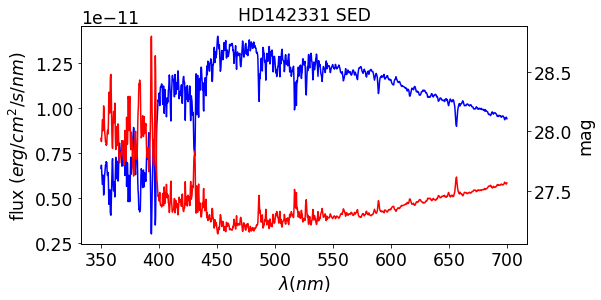

In [39]:
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.plot(sed_w,sed_f,'b')
ax.set_xlabel("$\\lambda (nm)$")
ax.set_ylabel("flux $(erg/cm^2/s/nm)$")
ax.set_title(targetname + " SED")
ax2=ax.twinx()
ax2.plot(sed_w,sed_m,'r-')
ax2.set_ylabel("mag")

## spectrum data

In [40]:
fullfilename=os.path.join(inputdir,inputfile)

In [41]:
with open(fullfilename, 'rb') as f:
    summary_content = pickle.load(f)

In [42]:
NBSPECTRA=len(summary_content)

In [43]:
msg=f" Number of selected files is {NBSPECTRA}"
logger.info(msg)

2022-10-13 11:17:48,220 imacdagoret.lal.in2p3.fr __main__[79854] INFO  Number of selected files is 46


In [44]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

### Read all files

In [45]:
infos, all_spectra = GetSpectra(summary_content)

In [46]:
infos.head()

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename,targetx_pix,targety_pix,rotangle,d2ccd
0,78,HD185975,2022-06-30T23:37:49.993,0.000000,2.023669,740.45,7.1,21.0,exposure_2022063000078_postisrccd_spectrum.fits,299.524256,1758.965936,-0.28,180.145908
1,79,HD185975,2022-06-30T23:38:33.068,0.011965,2.023198,740.45,7.1,21.0,exposure_2022063000079_postisrccd_spectrum.fits,299.234483,1757.731874,-0.28,181.060245
2,93,HD142331,2022-06-30T23:48:51.476,0.183745,1.268826,740.35,7.0,22.0,exposure_2022063000093_postisrccd_spectrum.fits,315.373188,1747.661772,-0.28,180.332161
3,94,HD142331,2022-06-30T23:49:34.392,0.195666,1.266461,740.35,7.0,22.0,exposure_2022063000094_postisrccd_spectrum.fits,314.705693,1747.696817,-0.28,180.378035
4,108,HD142331,2022-06-30T23:58:45.091,0.348638,1.237857,740.30,6.7,22.0,exposure_2022063000108_postisrccd_spectrum.fits,306.968231,1748.552541,-0.28,180.231958


In [47]:
all_spectra[0].head()

,all_lambdas,all_fluxes,all_fluxes_err,all_lambdas_order2,all_fluxes_order2,all_fluxes_err_order2
0,313.929574,-1.016252e-14,1.594000e-13,156.964787,0.0,0.0
1,314.285624,-8.355638e-15,1.325037e-13,157.142812,0.0,0.0
2,314.641671,-5.285023e-15,9.994084e-14,157.320835,0.0,0.0
3,314.997712,-1.139579e-14,7.834154e-14,157.498856,0.0,0.0
4,315.353744,-1.271754e-14,7.848975e-14,157.676872,0.0,0.0


In [48]:
N=len(infos)
NX=4
NY=N/NX
if NY != int(NY):
    NY= int(NY)+1
else:
    NY=int(NY)

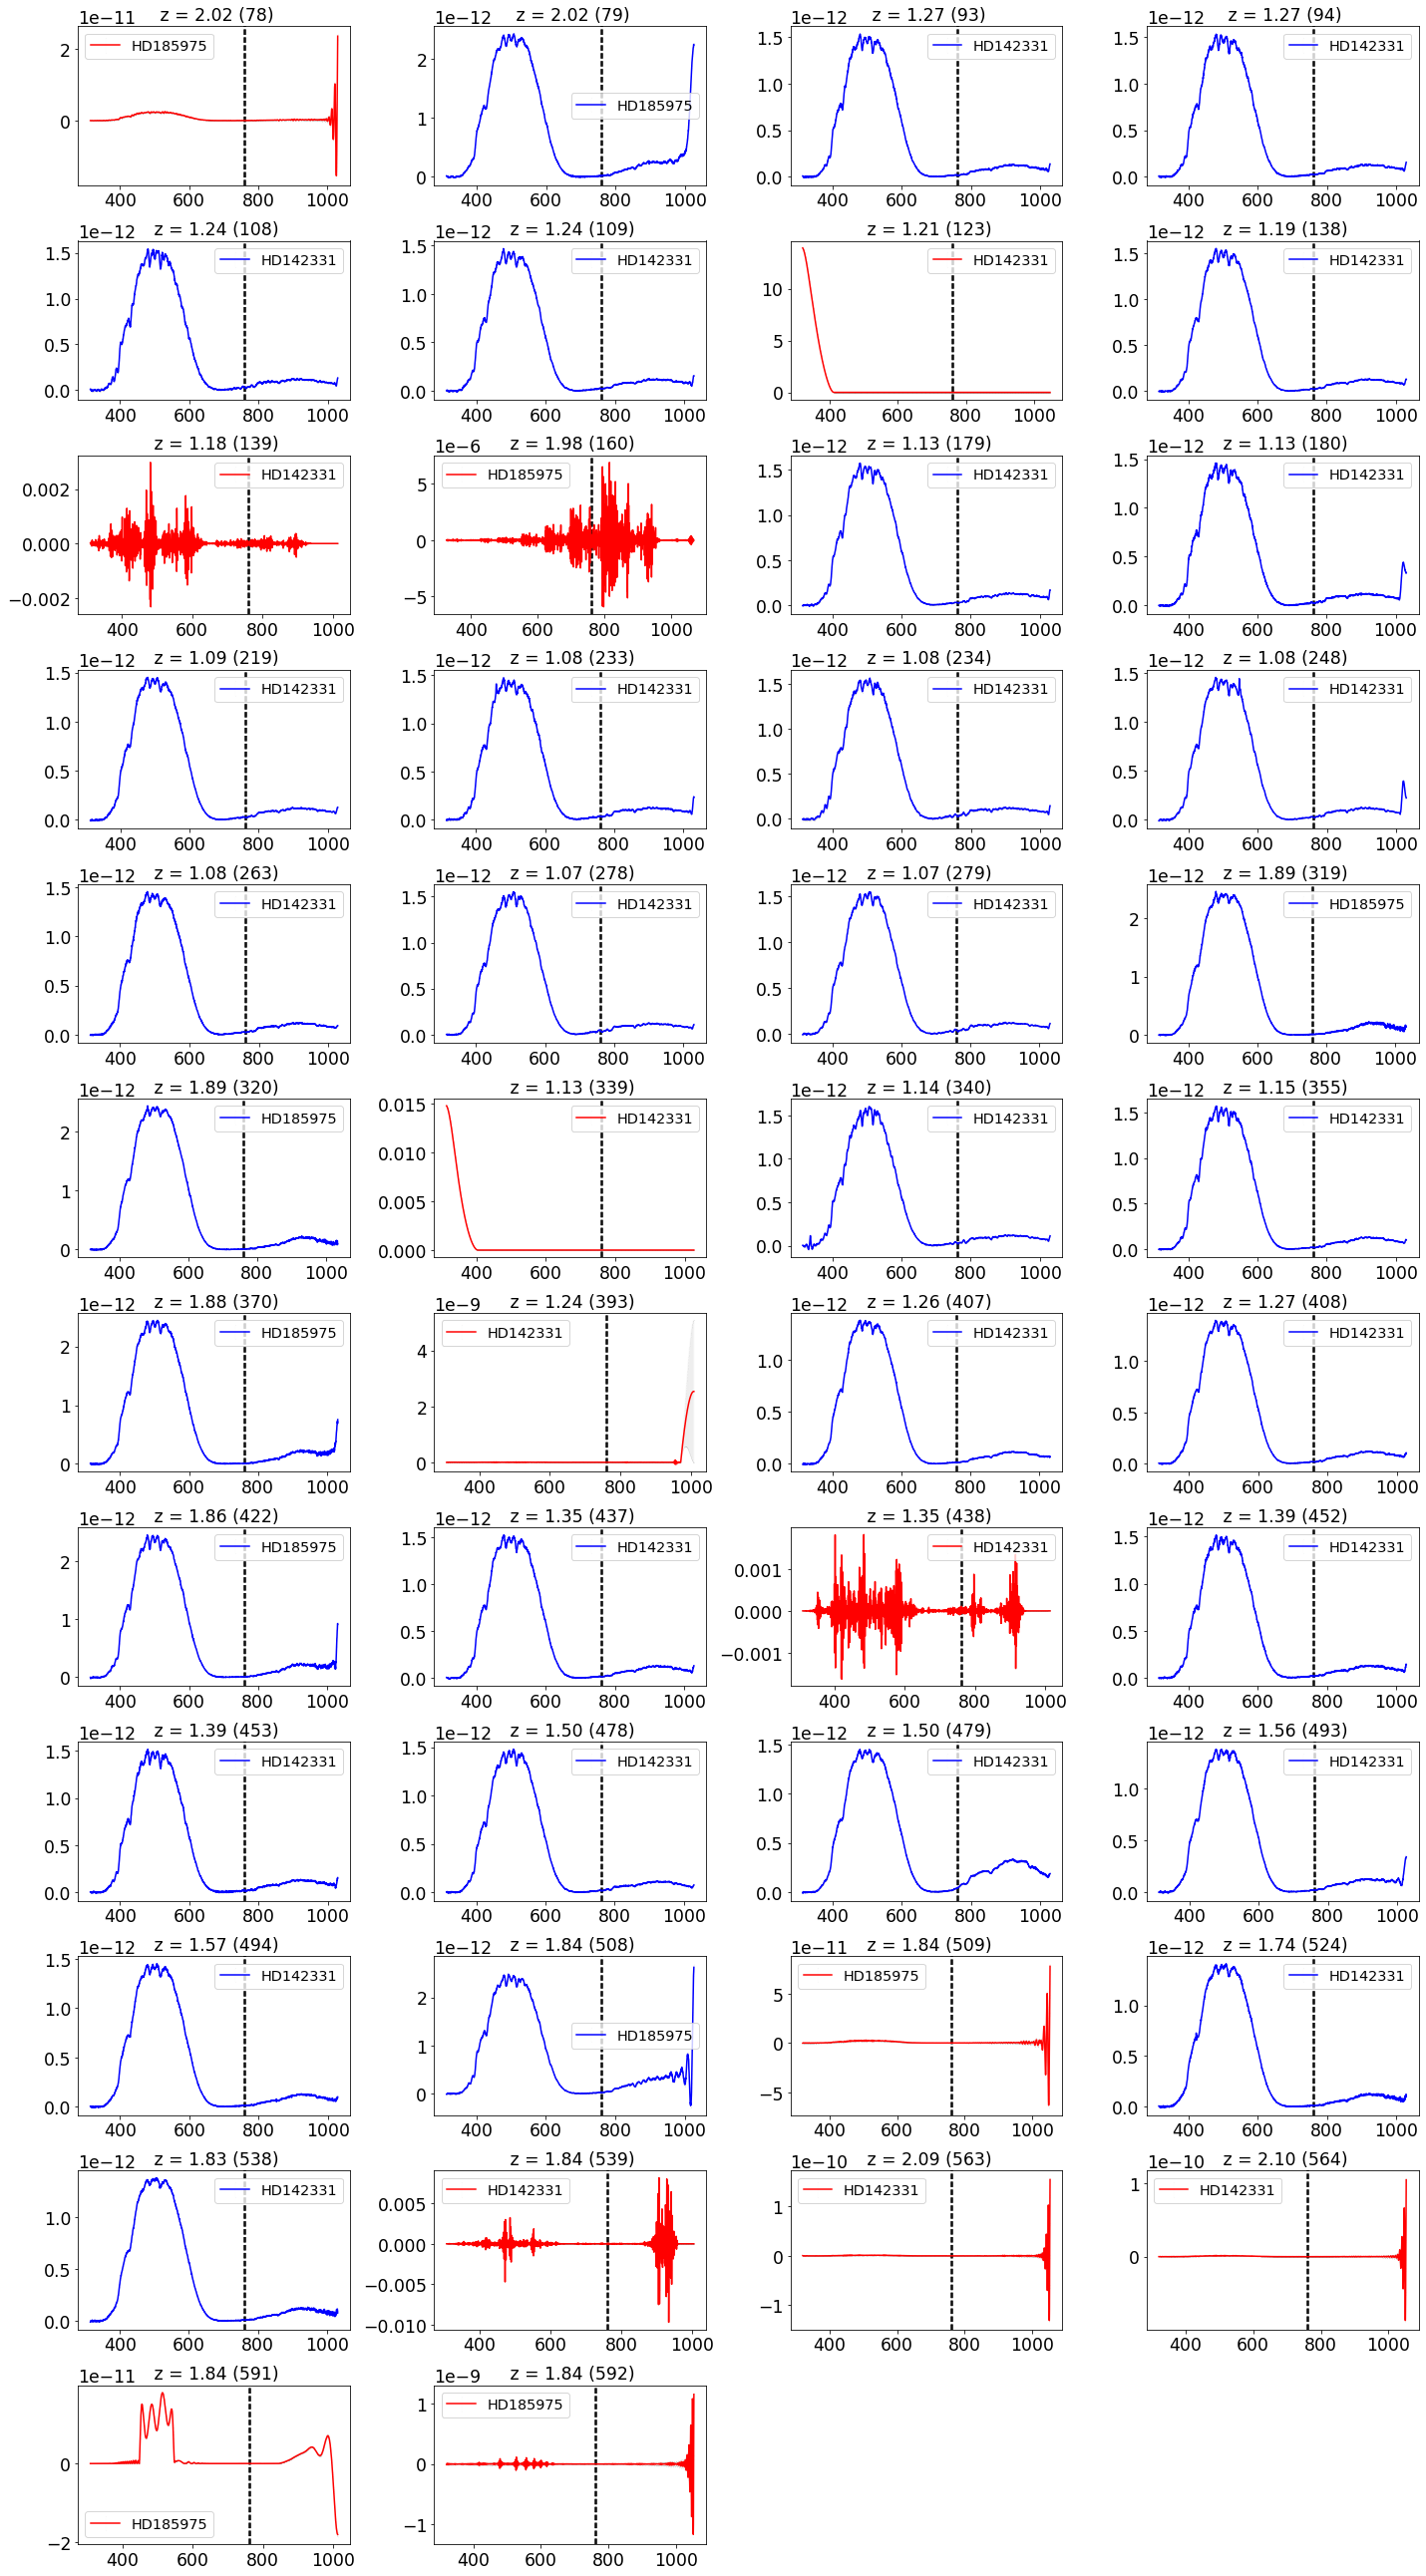

In [49]:
fig = plt.figure(figsize=(20,NY*3))

ny=0
nx=0

for idx in range(N):
    iy = idx//NX
    ix = (idx-iy*NX)
    
    ax=fig.add_subplot(NY,NX,idx+1)
    
    
    
    the_df=all_spectra[idx]
    
    airmassvalue = infos.iloc[idx]["airmass"]
    num = infos.iloc[idx]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    the_target = infos.iloc[idx]["object"]
    
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    if num in list_of_badnums1:
        thecolor="r"
    else:
        thecolor="b"
        
    # O2 line
    ax.axvline(O2_1.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '-', color=thecolor,capsize = 0.01, ecolor="k", elinewidth = .01,label=the_target)
    ax.set_title(label_airmass)
    ax.legend()
    
plt.tight_layout()

# Remove bad Spectra

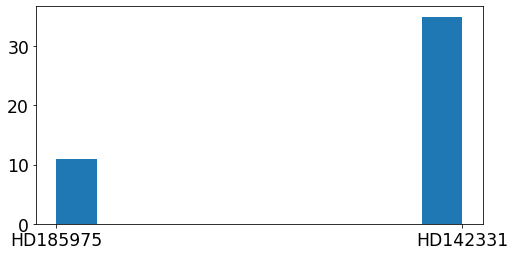

In [50]:
fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.hist(infos.object);

Text(0.5, 0.98, 'Variables to apply selection')

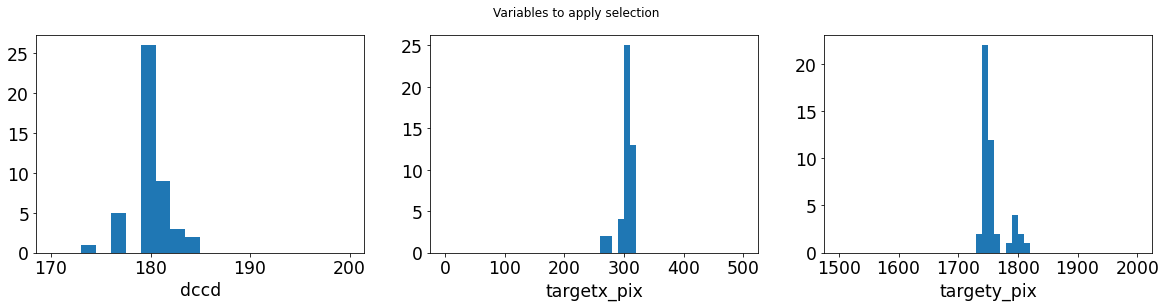

In [51]:
fig = plt.figure(figsize=(20,4))
ax=fig.add_subplot(1,3,1)
ax.hist(infos.d2ccd,bins=20,range=(170,200));
ax.set_xlabel("dccd")
ax=fig.add_subplot(1,3,2)
ax.hist(infos.targetx_pix,bins=50,range=(0,500));
ax.set_xlabel("targetx_pix")
ax=fig.add_subplot(1,3,3)
ax.hist(infos.targety_pix,bins=50,range=(1500,2000));
ax.set_xlabel("targety_pix")
plt.suptitle("Variables to apply selection")

## Define selection cut

In [52]:
#selection_cut = ((infos.d2ccd > 180) & (infos.d2ccd < 182)) & (infos.object == "mu. Col")
#bad_cut = ~selection_cut
#selection_cut = ((infos.d2ccd > 178) & (infos.d2ccd < 182)) & (infos.object == target)

selection_cut = ((infos.d2ccd > 178.5) & (infos.d2ccd < 181.5)) & (infos.object == target)
bad_cut = ~selection_cut

In [53]:
list_of_badnums2 = infos[bad_cut]["number"].values
list_of_badnums2 

array([78, 79, 123, 139, 160, 319, 320, 370, 393, 422, 438, 508, 509, 539,
       563, 564, 591, 592], dtype=object)

## Union of badnums

In [54]:
list_of_badnums = np.union1d(list_of_badnums1,list_of_badnums2)
list_of_badnums=np.unique(list_of_badnums)

In [55]:
infos, all_spectra = GetSpectraFiltered(summary_content,list_of_bad_spectra=list_of_badnums)

Remove spectrum 0 for exposure 78
Remove spectrum 1 for exposure 79
Remove spectrum 6 for exposure 123
Remove spectrum 8 for exposure 139
Remove spectrum 9 for exposure 160
Remove spectrum 19 for exposure 319
Remove spectrum 20 for exposure 320
Remove spectrum 21 for exposure 339
Remove spectrum 24 for exposure 370
Remove spectrum 25 for exposure 393
Remove spectrum 28 for exposure 422
Remove spectrum 30 for exposure 438
Remove spectrum 37 for exposure 508
Remove spectrum 38 for exposure 509
Remove spectrum 41 for exposure 539
Remove spectrum 42 for exposure 563
Remove spectrum 43 for exposure 564
Remove spectrum 44 for exposure 591
Remove spectrum 45 for exposure 592


In [56]:
print("Number of spectra : ",len(all_spectra))

Number of spectra :  27


In [57]:
infos.reset_index(drop=True, inplace=True)

In [58]:
infos

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename,targetx_pix,targety_pix,rotangle,d2ccd
0,93,HD142331,2022-06-30T23:48:51.476,0.183745,1.268826,740.35,7.0,22.0,exposure_2022063000093_postisrccd_spectrum.fits,315.373188,1747.661772,-0.28,180.332161
1,94,HD142331,2022-06-30T23:49:34.392,0.195666,1.266461,740.35,7.0,22.0,exposure_2022063000094_postisrccd_spectrum.fits,314.705693,1747.696817,-0.28,180.378035
2,108,HD142331,2022-06-30T23:58:45.091,0.348638,1.237857,740.30,6.7,22.0,exposure_2022063000108_postisrccd_spectrum.fits,306.968231,1748.552541,-0.28,180.231958
3,109,HD142331,2022-06-30T23:59:27.992,0.360555,1.235754,740.30,6.7,22.0,exposure_2022063000109_postisrccd_spectrum.fits,309.165731,1748.901977,-0.28,180.749001
4,138,HD142331,2022-07-01T00:18:32.201,0.678391,1.186018,740.35,6.4,23.0,exposure_2022063000138_postisrccd_spectrum.fits,306.259117,1749.226218,-0.28,180.097430
5,179,HD142331,2022-07-01T00:50:29.506,1.210976,1.126119,740.25,6.1,23.0,exposure_2022063000179_postisrccd_spectrum.fits,304.837688,1761.354184,-0.28,180.098631
6,180,HD142331,2022-07-01T00:51:12.411,1.222894,1.125071,740.25,6.1,23.0,exposure_2022063000180_postisrccd_spectrum.fits,303.024834,1762.330632,-0.28,180.045106
7,219,HD142331,2022-07-01T01:21:46.382,1.732330,1.090862,740.20,5.5,25.0,exposure_2022063000219_postisrccd_spectrum.fits,318.607068,1735.218676,-0.28,180.374005
8,233,HD142331,2022-07-01T01:30:59.473,1.885967,1.084397,740.15,5.3,28.0,exposure_2022063000233_postisrccd_spectrum.fits,313.731649,1743.381395,-0.28,179.748507
9,234,HD142331,2022-07-01T01:31:42.373,1.897883,1.083964,740.15,5.2,29.0,exposure_2022063000234_postisrccd_spectrum.fits,316.846978,1743.021460,-0.28,180.304459


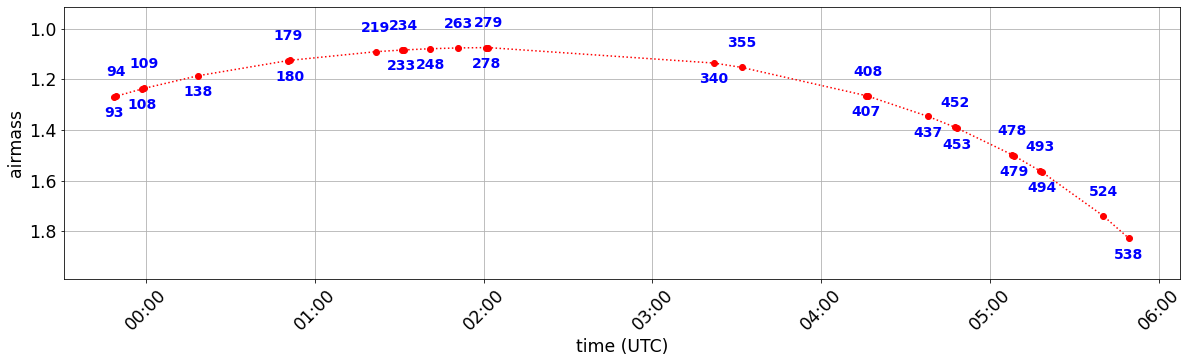

In [59]:
all_datetime = [ Time(str_time).to_datetime() for str_time in infos['dateobs'] ]
numbers = infos['number'].values
airmasses = infos['airmass'].values
N= len(numbers)

myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

fig=plt.figure(figsize=(20,5))
ax=fig.add_subplot(111)
#ax.plot(all_datetime,grey_attenuation,'bo:')
#ax.grid()
#plt.gcf().autofmt_xdate()
#ax.xaxis.set_major_formatter(myFmt)
#ax.xaxis.set_tick_params(rotation=45)
#ax.set_xlabel("time (UTC)")
#ax.set_title(f"Grey attenuation : {DATE} ({filterdisperser}, {target})")
#ax.set_ylabel("attenuation")
#ax2 = ax.twinx()

y_shift= 0.08

ax2=ax
ax2.plot(all_datetime,airmasses,'r:o')
ax2.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_tick_params(rotation=45)
ax2.set_xlabel("time (UTC)")
ax2.set_ylabel("airmass")
ax2.set_ylim(airmasses.min()-2*y_shift,airmasses.max()+2*y_shift)
ax2.invert_yaxis()
ax2.grid()


for index in range(N):
    textstr= str(numbers[index])
    if index%2 == 0:
        dy = y_shift
    else:
        dy = -y_shift
            
    ax2.text(all_datetime[index], airmasses[index] + dy , textstr,fontsize=14,fontweight="bold",ha='center',color="b" )


# Correct spectra for grey attenuation

In [60]:
NBSPECTRA = len(all_spectra)

In [61]:
assert NBSPECTRA == len(infos)

In [62]:
NBSPECTRA

27

In [63]:
len(list_of_greyattcoef)

0

In [64]:
def GetCorrectedGreyAttSpectra(in_infos,in_all_spectra,in_list_ofgreyattcoef):
    """
    """
    out_infos = in_infos
    out_infos["greyatt"] = in_list_ofgreyattcoef
    out_all_spectra = []
    
    idx=0
    for specdf in in_all_spectra:
        specdf['all_fluxes'] = specdf['all_fluxes'].multiply(1./in_list_ofgreyattcoef[idx])
        specdf['all_fluxes_err'] = specdf['all_fluxes_err'].multiply(1./in_list_ofgreyattcoef[idx])
        out_all_spectra.append(specdf)
    return out_infos, out_all_spectra
        

In [65]:
all_spectra[0].head()

,all_lambdas,all_fluxes,all_fluxes_err,all_lambdas_order2,all_fluxes_order2,all_fluxes_err_order2
0,314.209961,8.817390e-15,5.280339e-15,157.104981,0.0,0.0
1,314.564407,8.644236e-15,5.005798e-15,157.282204,0.0,0.0
2,314.918857,8.196670e-15,4.580192e-15,157.459429,0.0,0.0
3,315.273303,7.955958e-15,4.086547e-15,157.636652,0.0,0.0
4,315.627746,2.995948e-15,3.595923e-15,157.813873,0.0,0.0


In [66]:
if FLAG_CORREC_GREY_ATT:
    assert NBSPECTRA == len(list_of_greyattcoef)
    infos,all_spectra = GetCorrectedGreyAttSpectra(infos,all_spectra,list_of_greyattcoef)
else:
    list_of_greyattcoef = np.full(NBSPECTRA,1.)

In [67]:
all_spectra[0].head()

,all_lambdas,all_fluxes,all_fluxes_err,all_lambdas_order2,all_fluxes_order2,all_fluxes_err_order2
0,314.209961,8.817390e-15,5.280339e-15,157.104981,0.0,0.0
1,314.564407,8.644236e-15,5.005798e-15,157.282204,0.0,0.0
2,314.918857,8.196670e-15,4.580192e-15,157.459429,0.0,0.0
3,315.273303,7.955958e-15,4.086547e-15,157.636652,0.0,0.0
4,315.627746,2.995948e-15,3.595923e-15,157.813873,0.0,0.0


In [68]:
def plotlines(ax,ypos):
    
    ax.axvline(HDELTA.wavelength,color='orange')
    ax.annotate(HDELTA.label, xy=(HDELTA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HGAMMA.wavelength,color='orange')
    ax.annotate(HGAMMA.label, xy=(HGAMMA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HBETA.wavelength,color='orange')
    ax.annotate(HBETA.label, xy=(HBETA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HALPHA.wavelength,color='orange')
    ax.annotate(HALPHA.label, xy=(HALPHA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')

    ax.axvline(O2B.wavelength,color="blue")
    ax.annotate(O2B.label, xy=(O2B.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_1.wavelength,color="blue")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,color="blue")
    ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(H2O_1.wavelength,color="blue")
    ax.annotate(H2O_1.label, xy=(H2O_1.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.axvline(H2O_2.wavelength,color="blue")
    ax.annotate(H2O_2.label, xy=(H2O_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    

In [69]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [70]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

2022-10-13 11:17:56,572 imacdagoret.lal.in2p3.fr __main__[79854] INFO  Number of good spectra is 27


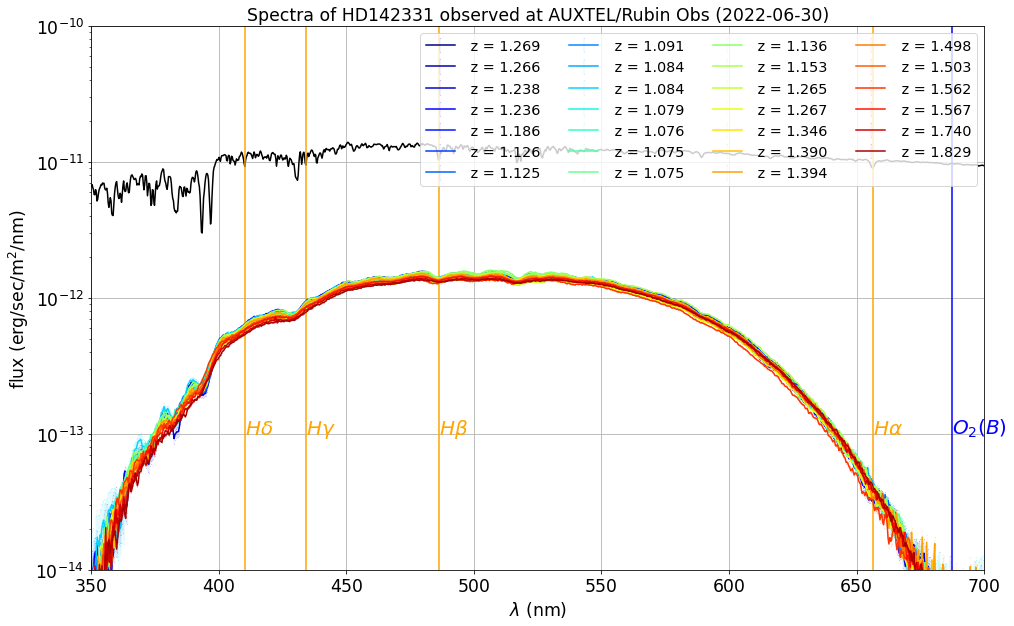

In [71]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.3f}"
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df.all_lambdas,the_df.all_fluxes,yerr=the_df.all_fluxes_err, fmt = '-', color=all_colors[ifile],capsize = 0.1, ecolor=all_colors[ifile], elinewidth = .1,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title)
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_ylim(1e-14,1e-10)
ax.set_yscale("log")
ax.legend(loc="upper right",ncol=4)

plotlines(ax,1e-13)

# Convert Not filtered spectra into Mag table

In [72]:
WL,Mags1,EMags1,AirM,Tim = ConvertToImage(infos,all_spectra,WLMIN= WLMINSEL ,WLMAX= WLMAXSEL)

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


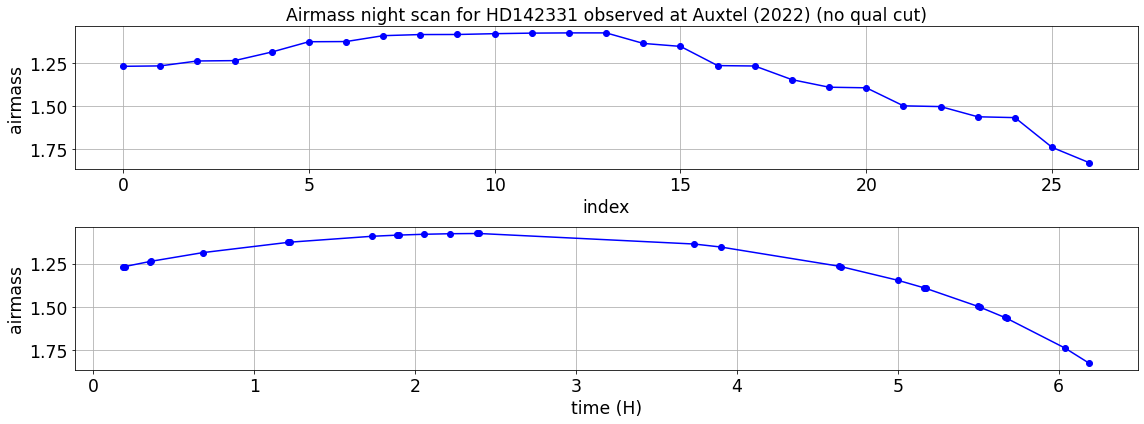

In [73]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_subplot(211)
ax1.plot(AirM,"bo-")
ax1.set_ylabel("airmass")
ax1.set_xlabel("index")
title=f"Airmass night scan for {target} observed at Auxtel (2022) (no qual cut)"
ax1.set_title(title)
ax1.grid()
ax1.invert_yaxis()

ax2=fig.add_subplot(212)
ax2.plot(Tim,AirM,"bo-")
ax2.set_ylabel("airmass")
ax2.set_xlabel("time (H)")
ax2.grid()
ax2.invert_yaxis()
plt.tight_layout()


In [74]:
fcn_sed_mag0 = interpolate.interp1d(sed_w,sed_m,bounds_error=False,fill_value=(0,0))
sed_mag0 =fcn_sed_mag0(WL)

In [75]:
MagsRef1=Mags1-sed_mag0
title="instrumental magnitude - sed magnitude vs time"

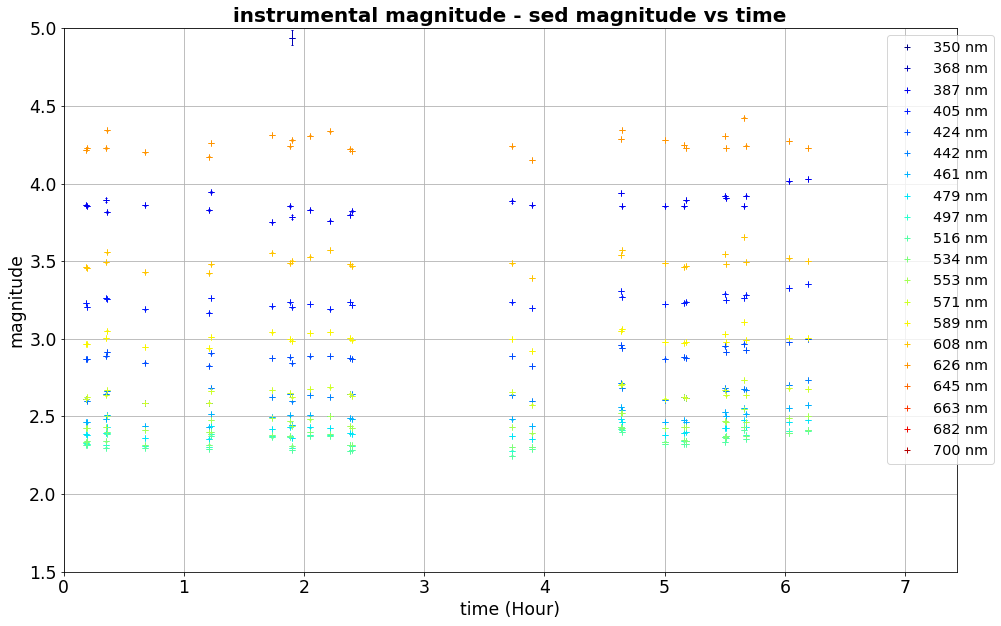

In [76]:
GetBouguerLinesTim(NPOINTSVIEW,WL,Tim,MagsRef1,EMags1,title=title,FLAG_PLOT=True,YMIN=1.5,YMAX=5,WLMIN=WLMINSEL,WLMAX=WLMAXSEL)

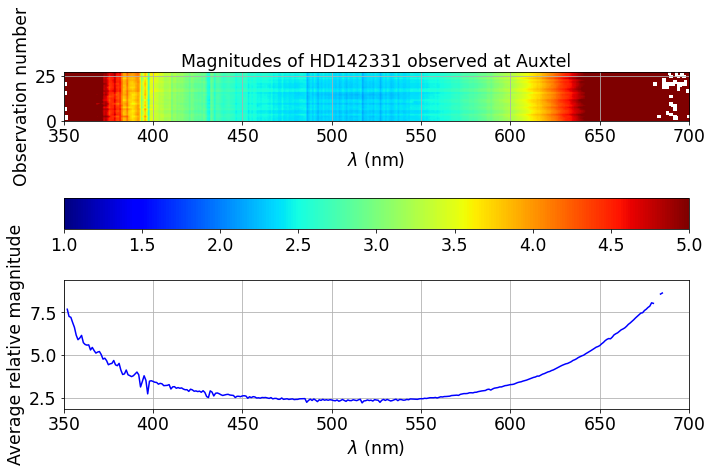

In [77]:
fig=plt.figure(figsize=(10,10))

gs = fig.add_gridspec(2, 1,height_ratios=[4,1])

ax1=fig.add_subplot(gs[0, :])

extent=(WL.min(),WL.max(),0,NBSPECTRA)
norm = mpl.colors.Normalize(vmin=1, vmax=5)
im=ax1.imshow(MagsRef1,origin="lower",norm=norm,extent=extent,cmap="jet")
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), ax=ax1, orientation="horizontal" )
ax1.grid()
ax1.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel("Observation number")
title=f"Magnitudes of {target} observed at Auxtel"
ax1.set_title(title)


ax2=fig.add_subplot(gs[1, :],sharex=ax1)

Y=np.average(MagsRef1,axis=0)
ax2.plot(WL,Y,"b-")
#ax2.set_ylim(2,4)
ax2.set_xlabel("$\lambda$ (nm)")
ax2.set_ylabel("Average relative magnitude")
ax2.grid()
plt.tight_layout()

# Filtered spectra

In [78]:
list_of_badnums

array([78, 79, 123, 139, 160, 319, 320, 339, 370, 393, 422, 438, 508, 509,
       539, 563, 564, 591, 592], dtype=object)

In [79]:
# Marc selection October 11th 2022

#list_of_badnums = [78, 79, 93,94, 108,109, 123, 138,139, 160, 179, 180, 219, 233, 234, 248, 263, 278, 279, 233, 234, 248, 263, 278, 279, 319, 320, 339, 340,355,370, 393, 422, 438, 508, 509,
#       539, 563, 564, 591, 592]
idx_to_remove = np.where(numbers < 400)[0] 
numbers_to_remove = numbers[idx_to_remove]
print("numbers_to_remove=",numbers_to_remove) 
list_of_badnums = np.unique(np.union1d(list_of_badnums,numbers_to_remove))
print("list_of_badnums",list_of_badnums)


numbers_to_remove= [93 94 108 109 138 179 180 219 233 234 248 263 278 279 340 355]
list_of_badnums [78 79 93 94 108 109 123 138 139 160 179 180 219 233 234 248 263 278 279
 319 320 339 340 355 370 393 422 438 508 509 539 563 564 591 592]


In [80]:
infos, all_spectra = GetSpectraFiltered(summary_content,list_of_bad_spectra=list_of_badnums)

Remove spectrum 0 for exposure 78
Remove spectrum 1 for exposure 79
Remove spectrum 2 for exposure 93
Remove spectrum 3 for exposure 94
Remove spectrum 4 for exposure 108
Remove spectrum 5 for exposure 109
Remove spectrum 6 for exposure 123
Remove spectrum 7 for exposure 138
Remove spectrum 8 for exposure 139
Remove spectrum 9 for exposure 160
Remove spectrum 10 for exposure 179
Remove spectrum 11 for exposure 180
Remove spectrum 12 for exposure 219
Remove spectrum 13 for exposure 233
Remove spectrum 14 for exposure 234
Remove spectrum 15 for exposure 248
Remove spectrum 16 for exposure 263
Remove spectrum 17 for exposure 278
Remove spectrum 18 for exposure 279
Remove spectrum 19 for exposure 319
Remove spectrum 20 for exposure 320
Remove spectrum 21 for exposure 339
Remove spectrum 22 for exposure 340
Remove spectrum 23 for exposure 355
Remove spectrum 24 for exposure 370
Remove spectrum 25 for exposure 393
Remove spectrum 28 for exposure 422
Remove spectrum 30 for exposure 438
Remove

In [81]:
infos

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename,targetx_pix,targety_pix,rotangle,d2ccd
26,407,HD142331,2022-07-01T04:15:55.381,4.634830,1.264656,740.35,4.5,21.0,exposure_2022063000407_postisrccd_spectrum.fits,305.505063,1748.311165,-0.28,179.998972
27,408,HD142331,2022-07-01T04:16:38.546,4.646820,1.267014,740.35,4.5,20.0,exposure_2022063000408_postisrccd_spectrum.fits,305.830797,1747.556336,-0.28,180.749000
29,437,HD142331,2022-07-01T04:37:50.325,5.000092,1.346323,740.20,4.5,17.0,exposure_2022063000437_postisrccd_spectrum.fits,309.768065,1746.756480,-0.28,180.748998
31,452,HD142331,2022-07-01T04:47:38.341,5.163430,1.390223,740.25,4.4,18.0,exposure_2022063000452_postisrccd_spectrum.fits,304.278050,1751.962224,-0.28,180.569290
32,453,HD142331,2022-07-01T04:48:21.387,5.175387,1.393637,740.25,4.4,18.0,exposure_2022063000453_postisrccd_spectrum.fits,303.852124,1751.390639,-0.28,180.387743
33,478,HD142331,2022-07-01T05:07:48.599,5.499613,1.498387,740.20,4.4,16.0,exposure_2022063000478_postisrccd_spectrum.fits,309.066155,1751.128385,-0.28,180.463166
34,479,HD142331,2022-07-01T05:08:31.674,5.511578,1.502744,740.20,4.4,16.0,exposure_2022063000479_postisrccd_spectrum.fits,312.634685,1752.048150,-0.28,180.374009
35,493,HD142331,2022-07-01T05:17:42.011,5.664449,1.561919,740.10,4.3,18.0,exposure_2022063000493_postisrccd_spectrum.fits,310.629653,1753.978653,-0.28,180.749074
36,494,HD142331,2022-07-01T05:18:24.909,5.676366,1.566832,740.10,4.3,18.0,exposure_2022063000494_postisrccd_spectrum.fits,310.663395,1756.868223,-0.28,180.373795
39,524,HD142331,2022-07-01T05:40:09.668,6.038799,1.739666,740.20,4.3,17.0,exposure_2022063000524_postisrccd_spectrum.fits,305.615973,1742.878281,-0.28,180.374051


# Convert Not filtered spectra into Mag table

In [82]:
NBSPECTRA=len(all_spectra)

In [83]:
assert NBSPECTRA == len(infos)

In [84]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [85]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

2022-10-13 11:18:02,327 imacdagoret.lal.in2p3.fr __main__[79854] INFO  Number of good spectra is 11


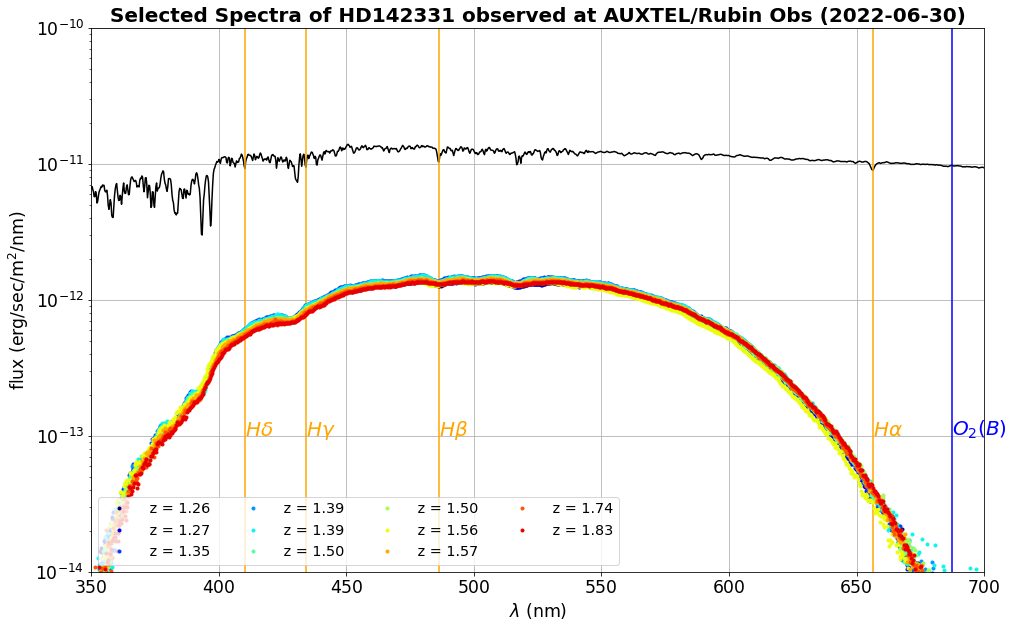

In [86]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_ylim(1e-14,1e-10)
ax.set_yscale("log")
ax.legend(loc="lower left",ncol=4)

plotlines(ax,1e-13)

In [87]:
df = pd.read_csv("data/absorption_pattern.csv")
wlpt,o2,o3,h2o,no2 = atmpatt_Dataf_to_np(df)

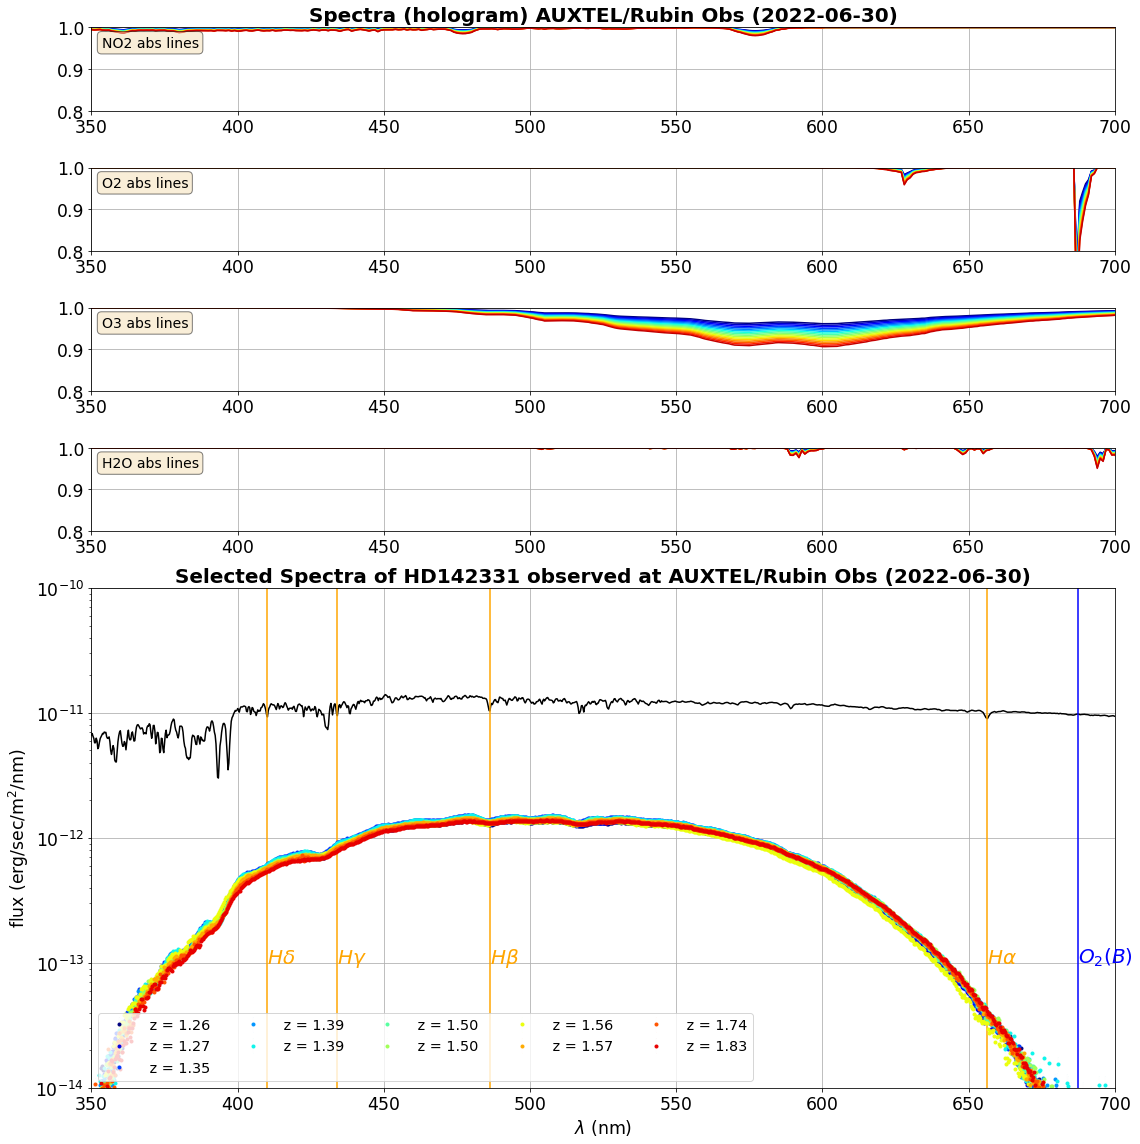

In [88]:
figsize=(16,16)

NOBS = o2.shape[1]
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig=plt.figure(figsize=figsize)
title =f"Spectra (hologram) {SITE} ({DATE})"


gs = gridspec.GridSpec(5, 1,height_ratios=[0.5,0.5,0.5,0.5,3] ,figure=fig)

# NO2    
ax=fig.add_subplot(gs[0,0])
for index in np.arange(NOBS):   
    ax.plot(wlpt,no2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "NO2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_title(title,fontsize=20,fontweight='bold')
main_ax = ax



# O2    
ax=fig.add_subplot(gs[1,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
#ax.set_title(title)


# Ozone
ax=fig.add_subplot(gs[2,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o3[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O3 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# H2O
ax=fig.add_subplot(gs[3,0], sharex=main_ax)

for index in np.arange(NOBS):   
    ax.plot(wlpt,h2o[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.grid()
textstr = "H2O abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# spectrum
ax=fig.add_subplot(gs[4,0], sharex=main_ax)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-')
#ax.set_xlim(350,1000)
ax.set_ylim(1e-14,1e-10)
ax.set_yscale("log")
ax.legend(loc="lower left",ncol=5)
plotlines(ax,1e-13)
plt.tight_layout()


/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-pac

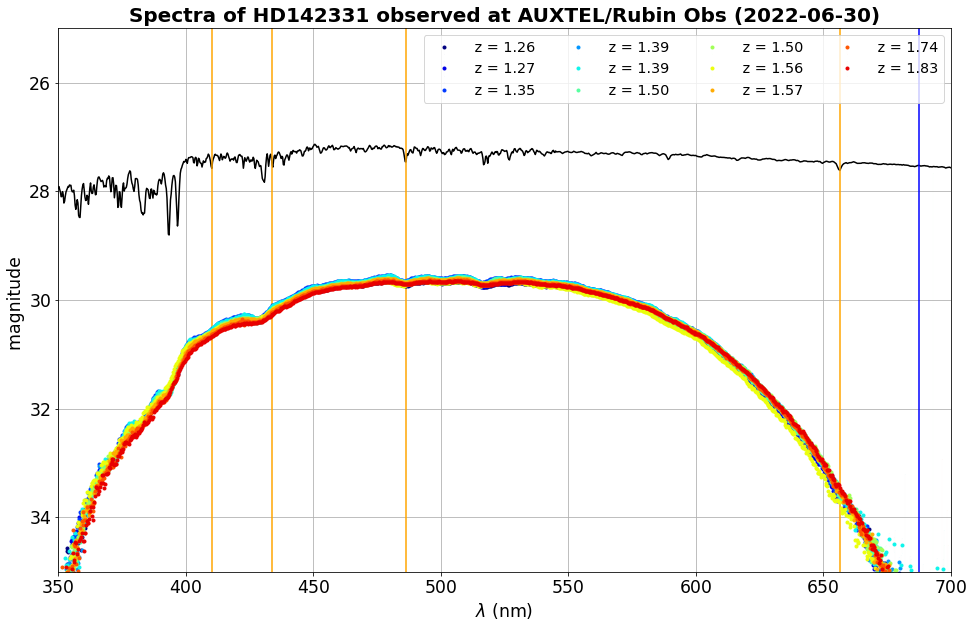

In [89]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=the_df=all_spectra[ifile]

    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"
    
    #ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
    mag = -2.5*np.log10(the_df["all_fluxes"])
    errmag = 2.5/np.log(10)*the_df["all_fluxes_err"]/(the_df["all_fluxes"])
    ax.errorbar(the_df["all_lambdas"],mag,yerr=errmag, fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude ")
title=f"Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_m,'k-')
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_ylim(25,35)
ax.invert_yaxis()
ax.legend(loc="upper right",ncol=4)
plotlines(ax,1e-13)

## Convert to image

In [90]:
WL,Mags2,EMags2 ,AirM,Tim = ConvertToImage(infos,all_spectra, WLMIN= WLMINSEL ,WLMAX= WLMAXSEL )

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


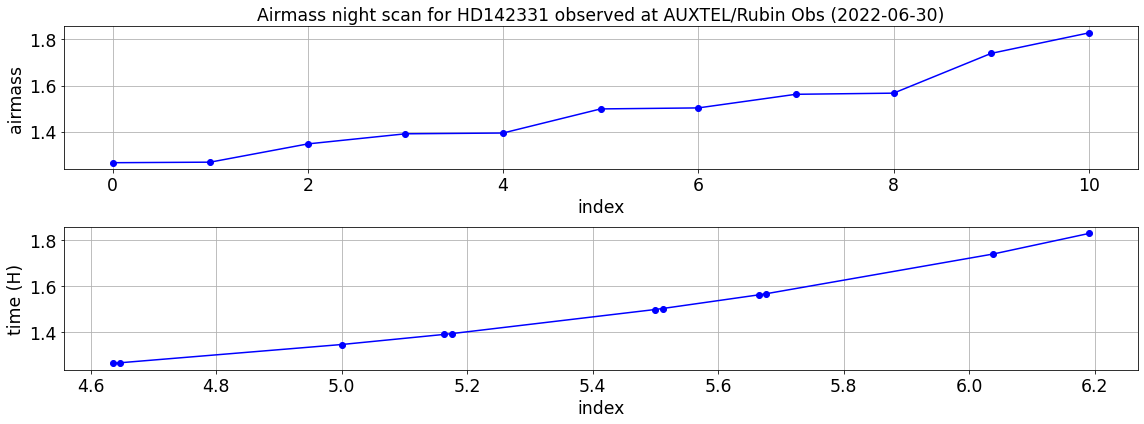

In [91]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_subplot(211)
ax1.plot(AirM,"bo-")
ax1.set_ylabel("airmass")
ax1.set_xlabel("index")
title=f"Airmass night scan for {target} observed at {SITE} ({DATE})"
ax1.set_title(title)
ax1.grid()


ax2=fig.add_subplot(212)
ax2.plot(Tim,AirM,"bo-")
ax2.set_ylabel("time (H)")
ax2.set_xlabel("index")
ax2.grid()

plt.tight_layout()

# Bouguer line

### Integration of SED in bin

In [92]:
wl_center=500.
#wl_binwidth=WLBINWIDTH
wl_halfbinwidth=WLBINWIDTH/2.

In [93]:
def IntegSEDinBin(wl,sed,wlcenter,wlbinwidth=20):
    """
    """

    wlmin=wlcenter-wlbinwidth/2.
    wlmax=wlcenter+wlbinwidth/2.
       
    wl = wl
    fl = sed
          
    index_wl = np.where(np.logical_and(wl>=wlmin,wl<wlmax))[0]
    wl2= wl[index_wl]
    fl2= fl[index_wl]
  
    integ_fl = np.trapz(fl2,wl2) 
    #integ_fl = np.sum(fl2[:-1]*np.diff(wl2))          
    mags = -2.5*np.log10(integ_fl)
    
    return integ_fl, mags, wl2,fl2
    

Text(0, 0.5, '$d\\lambda$ (nm)')

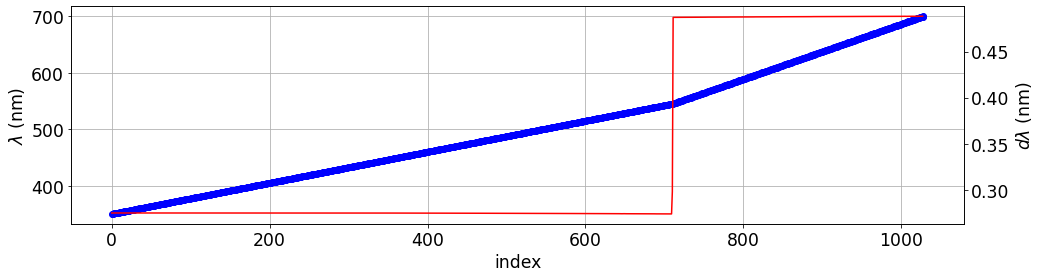

In [94]:
fig=plt.figure(figsize=(16,4))
ax=fig.add_subplot(1,1,1)
ax.plot(sed_w,'bo-')
ax.grid()
ax.set_ylabel("$\lambda$ (nm)")
ax.set_xlabel("index")
ax2 = ax.twinx()
ax2.plot(np.diff(sed_w),"r-")
ax2.set_ylabel("$d\lambda$ (nm)")

## Must interpolate SED

In [95]:
WL_SED = np.arange(sed_w.min(),sed_w.max(),0.1)

In [96]:
fcn_sed = interpolate.interp1d(sed_w,sed_f,bounds_error=False,fill_value=(0,0))

In [97]:
sed_integ_fl,sed_integ_mag, sed_wl_bin,sed_fl_bin = IntegSEDinBin(WL_SED,fcn_sed(WL_SED),wl_center,wlbinwidth=WLBINWIDTH)

Text(0.5, 0.98, '$\\lambda$ = 500.0 $\\pm$ 15.0 nm')

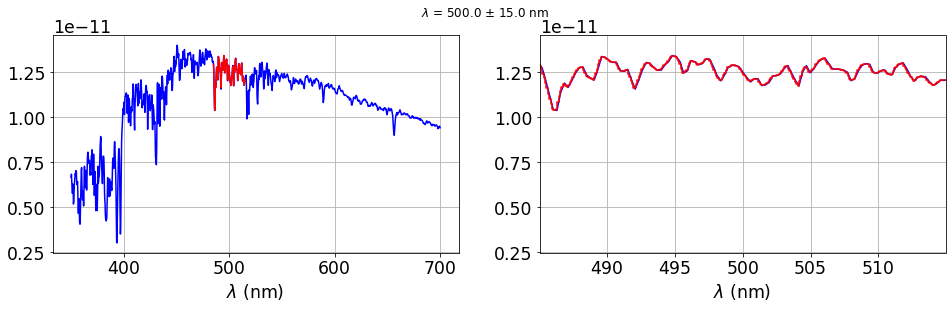

In [98]:
fig=plt.figure(figsize=(16,4))
ax= fig.add_subplot(121)             
ax.plot(sed_w,sed_f,'b-')
ax.plot(sed_wl_bin,sed_fl_bin,'r-')
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax= fig.add_subplot(122)             
ax.plot(sed_w,sed_f,'b-')
ax.step(sed_wl_bin,sed_fl_bin,'r-')
ax.set_xlim(sed_wl_bin[0],sed_wl_bin[-1])
ax.set_xlabel("$\lambda$ (nm)")
ax.grid()
title=f"$\lambda$ = {wl_center} $\pm$ {wl_halfbinwidth} nm"
plt.suptitle(title)

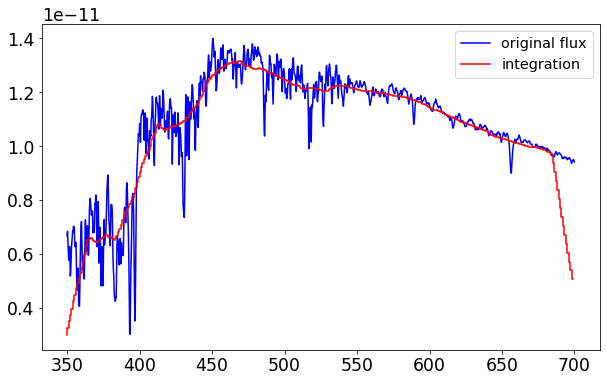

In [99]:
wl_binwidth=30.0
all_wl_center = np.arange(WLMINSEL,WLMAXSEL,1)
all_sed_integ_flux = np.zeros(len(all_wl_center))
idx=0
for wl0 in all_wl_center:
    sed_integ_fl,sed_integ_mag, sed_wl_bin,sed_fl_bin = IntegSEDinBin(WL_SED,fcn_sed(WL_SED),wl0,wlbinwidth=WLBINWIDTH)
    all_sed_integ_flux[idx] = sed_integ_fl
    idx+=1

plt.plot(sed_w,sed_f,'b-',label="original flux")    
plt.step(all_wl_center,all_sed_integ_flux/wl_binwidth,'r-',label='integration')
plt.legend()    

### Integration of measured flux

In [100]:
def ComputeOneBouguerLine(infos,all_spectra,wlcenter,wlbinwidth=20):
    """
    """

    wlmin=wlcenter-wlbinwidth/2.
    wlmax=wlcenter+wlbinwidth/2.
    
    airmasses = infos["airmass"].values
    numbers = infos["number"].values
    
    N=len(all_spectra)
    
    fluxes = np.zeros(N)
    efluxes = np.zeros(N)
    
    
    
    idx=0
    for spec in all_spectra:
        wl = spec["all_lambdas"].values
        fl = spec["all_fluxes"].values
        efl = spec["all_fluxes_err"].values
        
        index_wl = np.where(np.logical_and(wl>=wlmin,wl<wlmax))[0]
        wl2= wl[index_wl]
        fl2= fl[index_wl]
        efl2= efl[index_wl]
        
        integ_fl = np.trapz(fl2,wl2) # compute np.sum(fl2[:-1]*np.diff(wl2))
        integ_efl2 = np.trapz(efl2**2,wl2) # np.sum((efl2**2)[:-1]*np.diff(wl2))
        integ_efl = np.sqrt(integ_efl2)
        
        fluxes[idx] = integ_fl
        efluxes[idx] = integ_efl
 
        
        idx+=1
        
    mags = -2.5*np.log10(fluxes)
    emags = 2.5/np.log(10)*efluxes/fluxes
    
    return airmasses,numbers,fluxes,efluxes,mags,emags
    

In [101]:
wl_center=500.
wl_binwidth=WLBINWIDTH
wl_halfbinwidth=WLBINWIDTH/2.

In [102]:
airmasses,numbers,fluxes,efluxes,mags,emags = ComputeOneBouguerLine(infos,all_spectra,wlcenter=wl_center,wlbinwidth=WLBINWIDTH)

In [103]:
def FitAndPlot(X,Y,EY,tags,wl0,wlw,FLAG_PLOT=True,xlabel="airmass",ylabel="magnitude"):
    """
    """
    
    N=len(X)
    # wavelength bin colors
    
    # fit
    the_x = X
    the_y = Y
    #p(x) = p[0] * x + p[1]
    popt,cov = np.polyfit(the_x, the_y, 1,cov=True)
    p = np.poly1d(popt) 
    intercept =  popt[-1]
    slope =  popt[0]

    # straight line
    x_fit = np.linspace(0,X.max()+0.5)
    y_fit= p(x_fit)

       
    perr=np.sqrt(np.diag(cov))
    nstd=1
    # sigma^2 = (dp(x)/dp0)^2 sigma(p0)^2  + (dp(x)/dp1)^2 sigma(p1)^2 + 2(dp(x)/dp0).(dp(x)/dp1) cov(p0,p1)
    # sigma^2 = x^2.sigma(p0)^2  + sigma(p1)^2 + 2*x**cov(p0,p1)
    sigmaf=np.sqrt(x_fit**2*cov[0,0]+cov[1,1]+x_fit*(cov[0,1]+cov[1,0]))
    y_fit_up=y_fit+nstd*sigmaf
    y_fit_dw=y_fit-nstd*sigmaf

    y_scale = y_fit.max()-y_fit.min()
    y_shift = y_scale/8.
    
    if FLAG_PLOT:
        jet = plt.get_cmap('jet')
        cNorm_points = colors.Normalize(vmin=0, vmax=N)
        scalarMap_points = cmx.ScalarMappable(norm=cNorm_points, cmap=jet)
        all_colors_points = scalarMap_points.to_rgba(np.arange(N), alpha=1)
        
        
        textstr = '\n'.join((r'$slope=%.3f$' % (slope, ),r'$intercept=%.3f$' % (intercept,)))
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
      
        
        fig = plt.figure(figsize=(16,4))
        ax=fig.add_subplot(111)
        ax.scatter(X,Y,s=100,color=all_colors_points)
        ax.errorbar(X,Y, yerr=EY, xerr=None, fmt='.',color="k",ecolor="grey", elinewidth=2, capsize=.01)
        label = f"$\lambda$ = {wl0:.0f} $\pm$ {wlw:.0f} nm"
        ax.plot(x_fit,y_fit,'k-',label=label)
        ax.fill_between(x_fit,y_fit_up , y_fit_dw , alpha=.25, color="gray")
        ax.legend() 
        ax.set_xlim(x_fit.min(),x_fit.max())
        ax.set_ylim(y_fit.min(),y_fit.max())
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        # place a text box in upper left in axes coords
        ax.text(0.8, 0.25, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        
        
        for index in range(N):
            textstr= str(tags[index])
            if index%2 == 0:
                dy = y_shift
            else:
                dy = -y_shift
            
            ax.text(X[index], Y[index] + dy , textstr,fontsize=14,fontweight="bold",ha='center',color=all_colors_points[index] )
            
            
        
        plt.show()
    return intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw


### see one Bouguer line

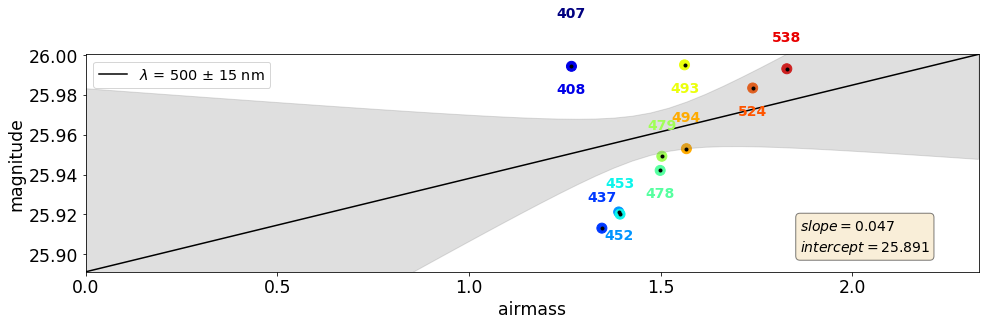

In [104]:
intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl_center,wl_halfbinwidth,FLAG_PLOT=True,xlabel="airmass",ylabel="magnitude")

###  See many bouguer line

In [105]:
all_wl_center = np.linspace(WLMINSEL,WLMAXSEL,NPOINTSVIEW)  

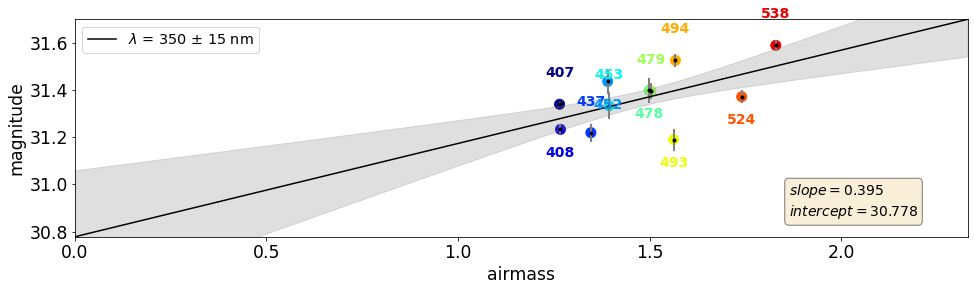

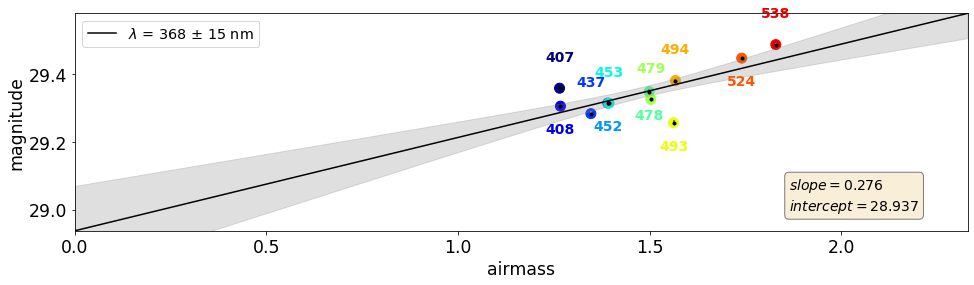

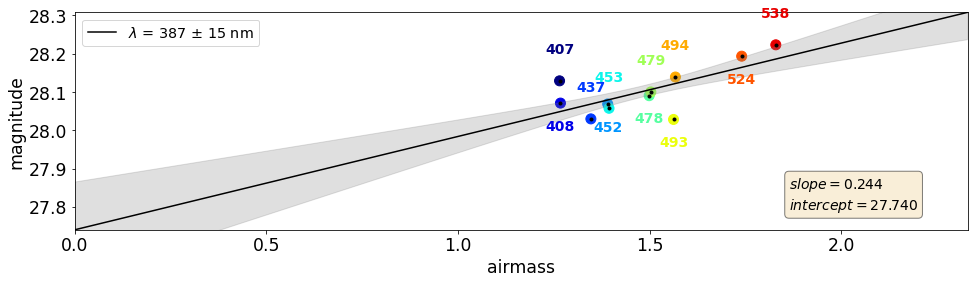

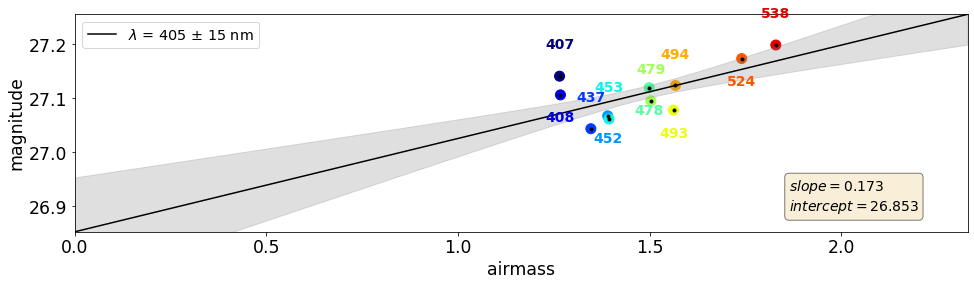

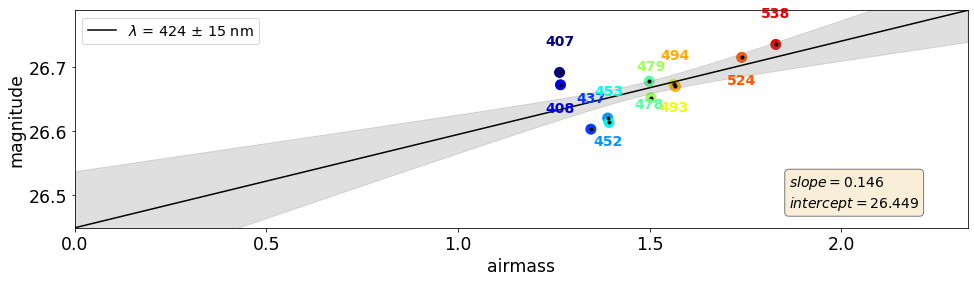

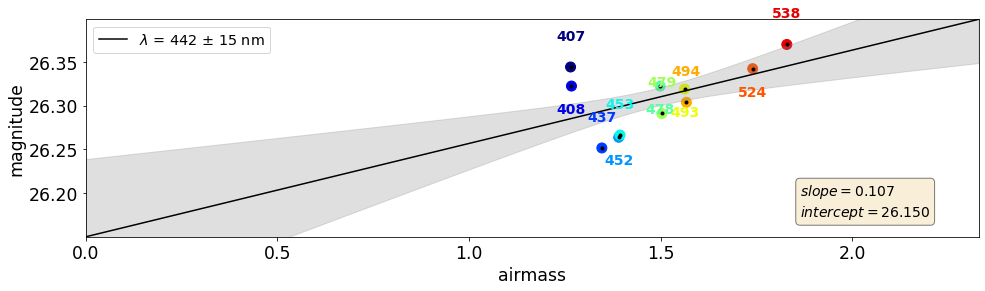

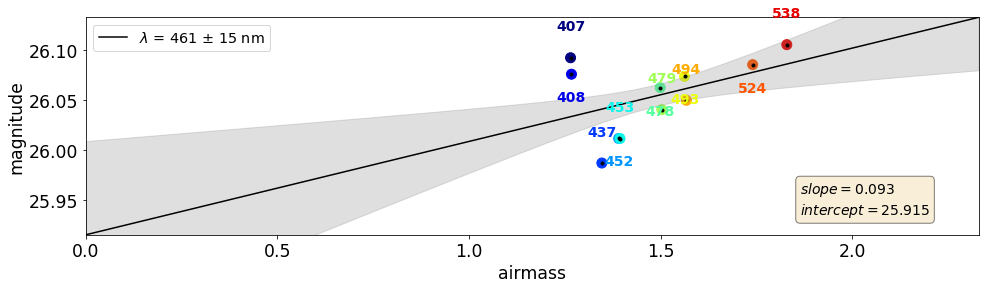

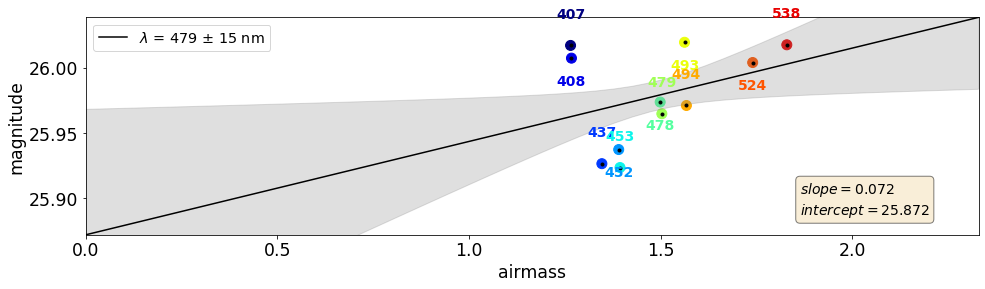

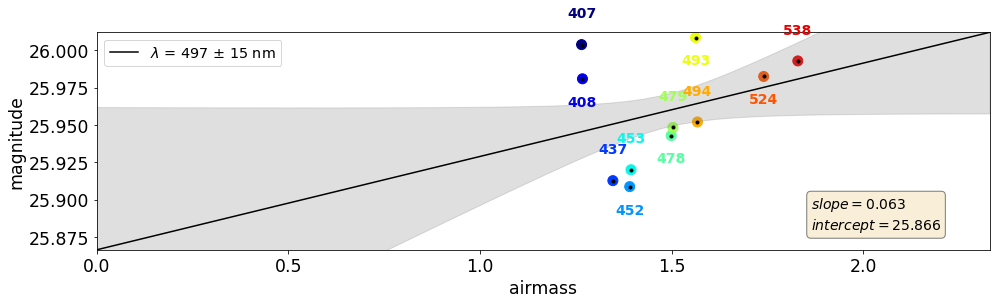

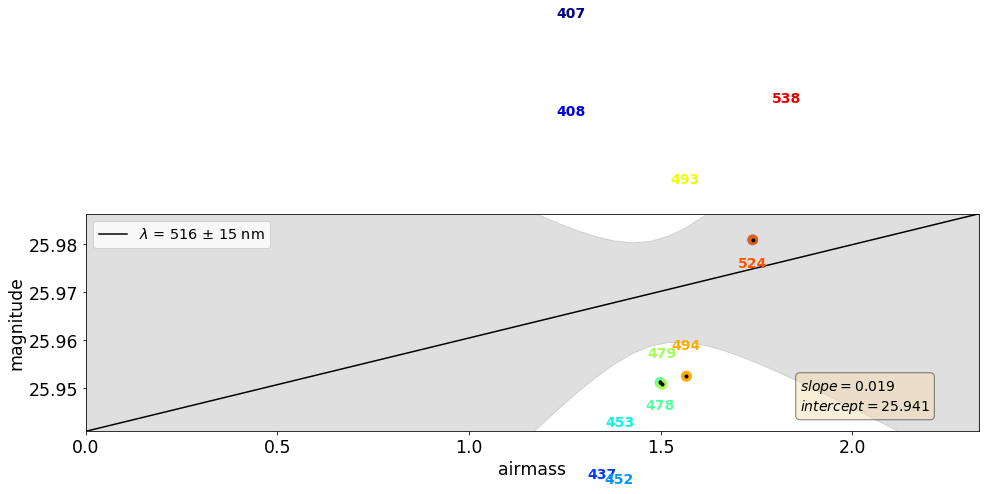

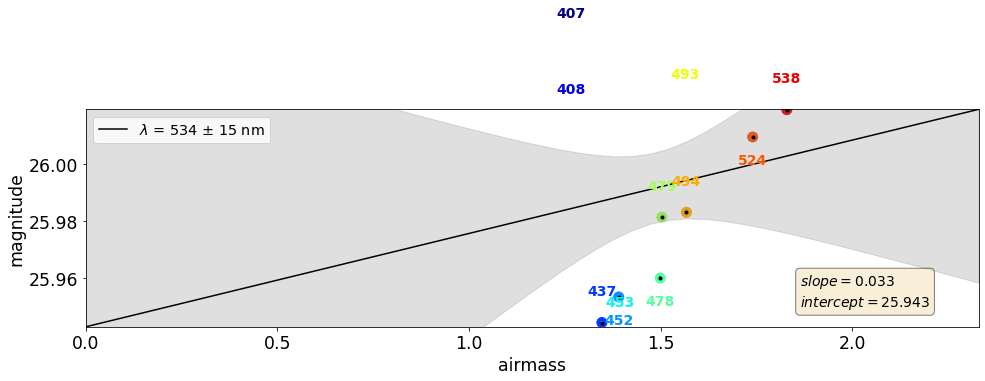

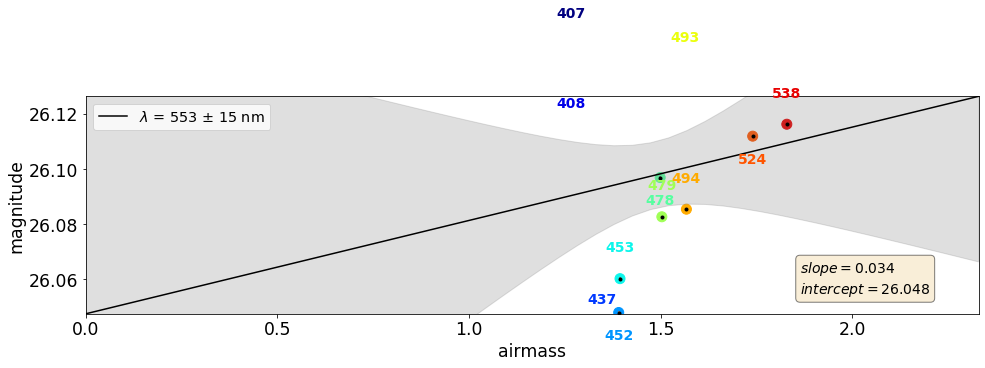

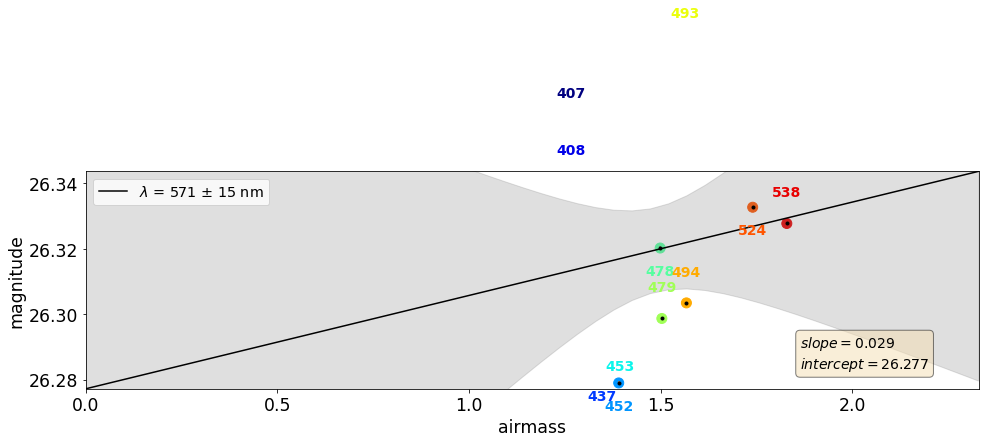

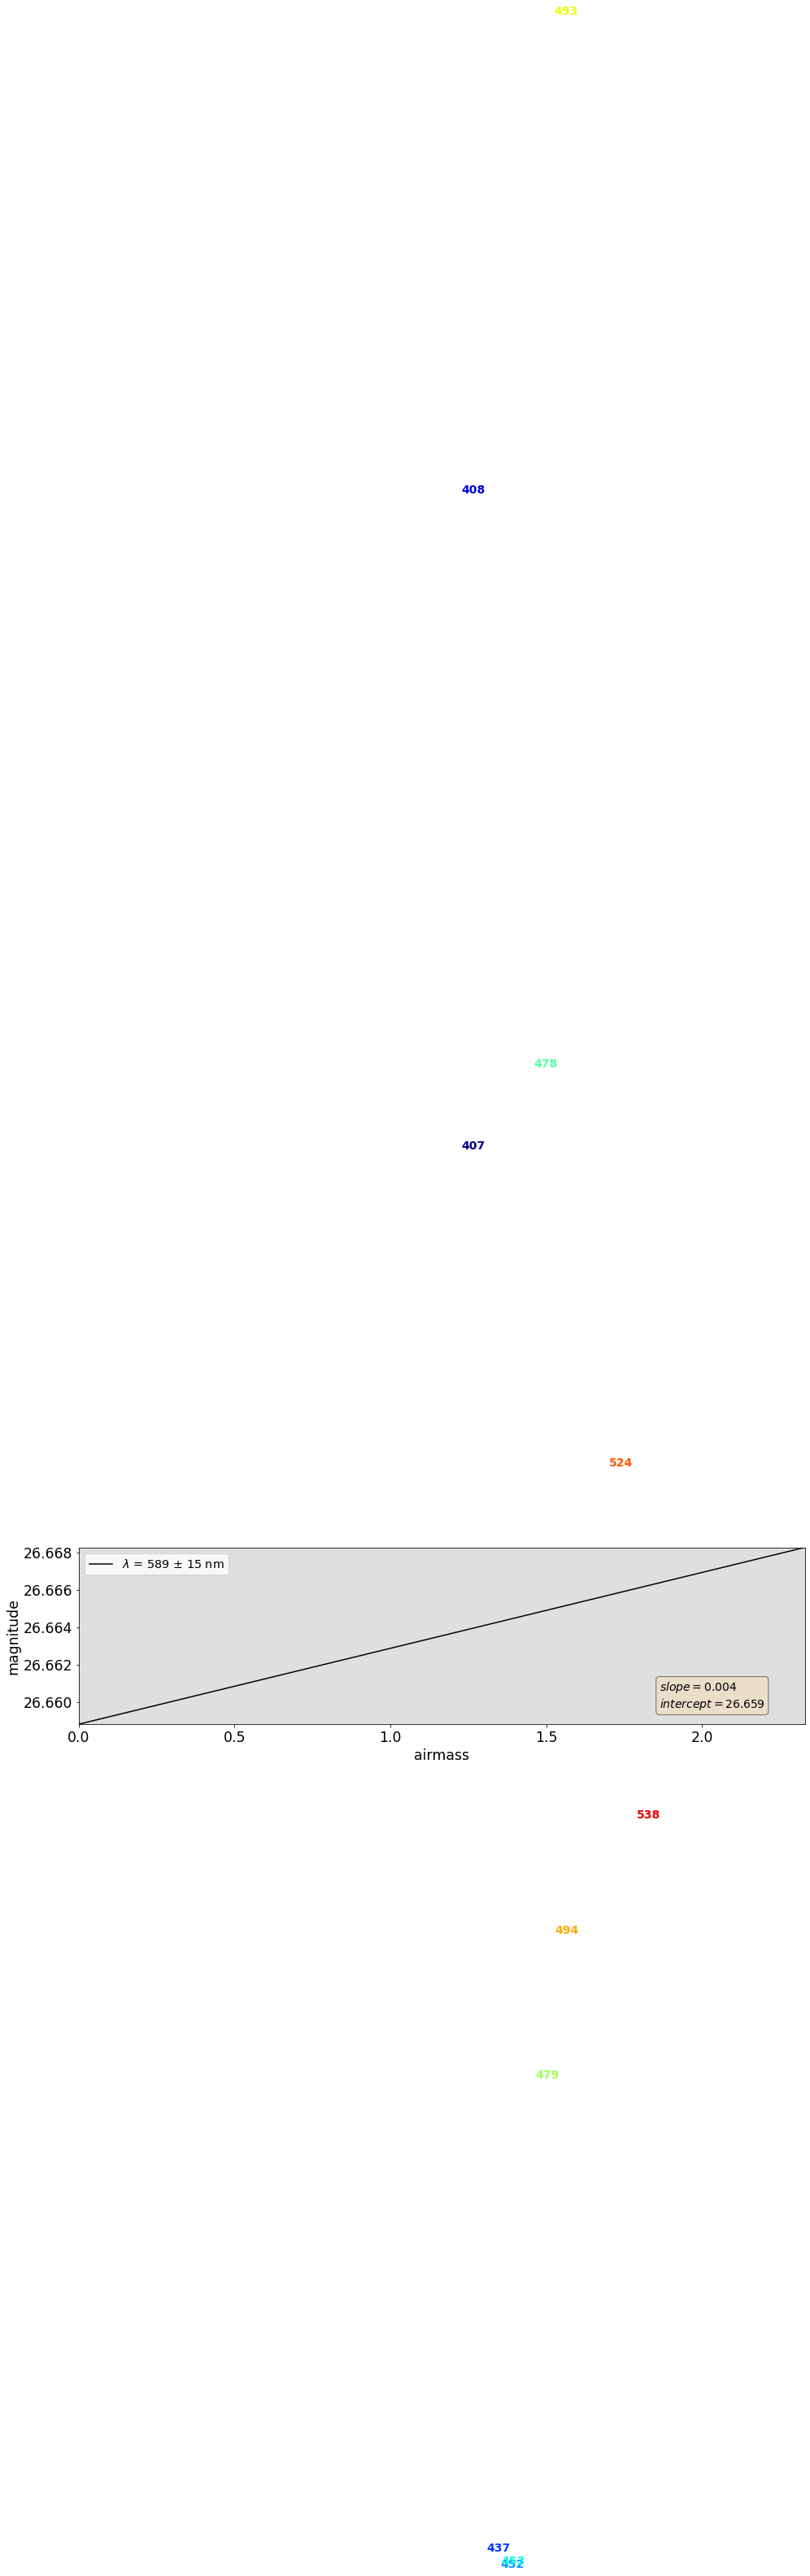

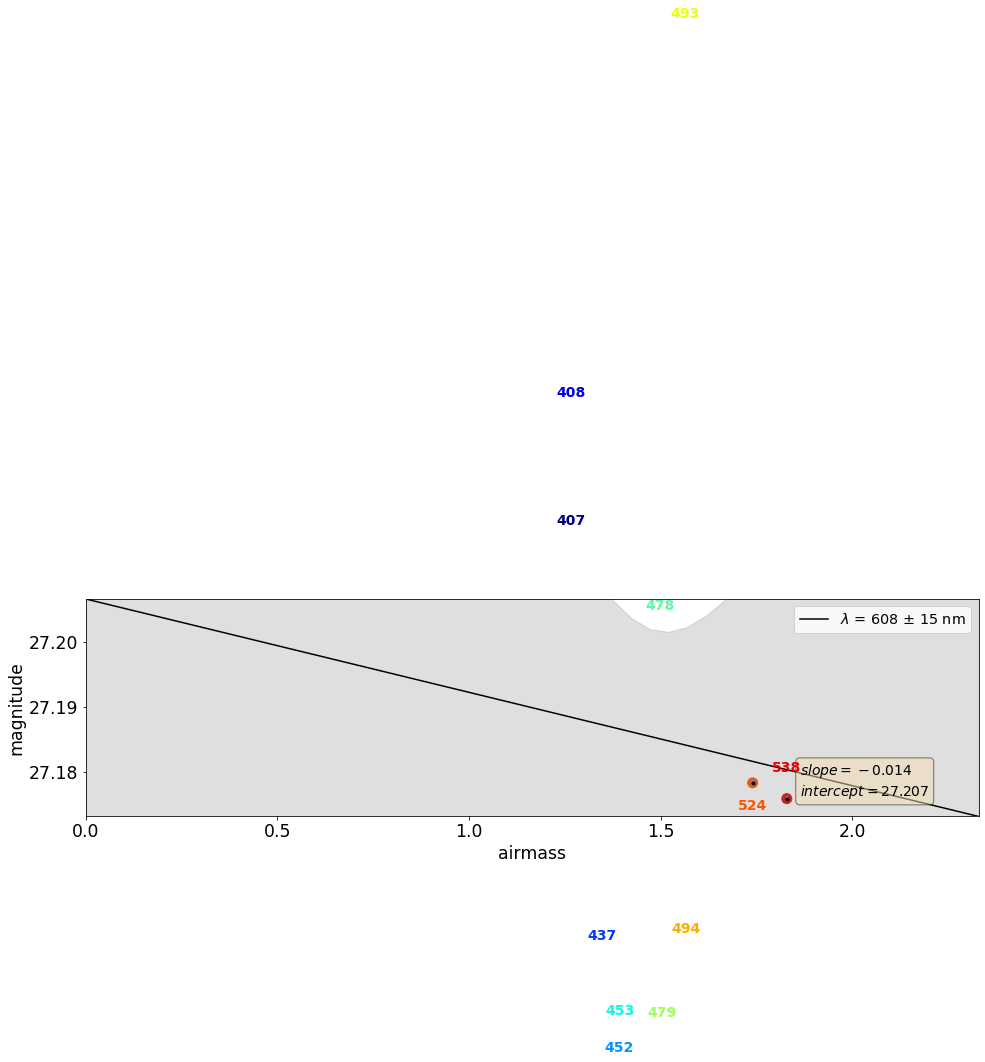

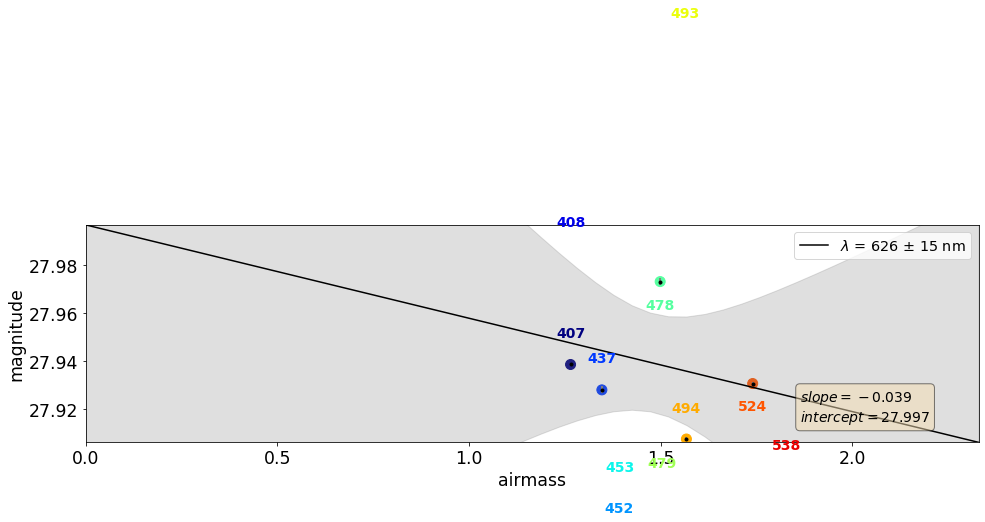

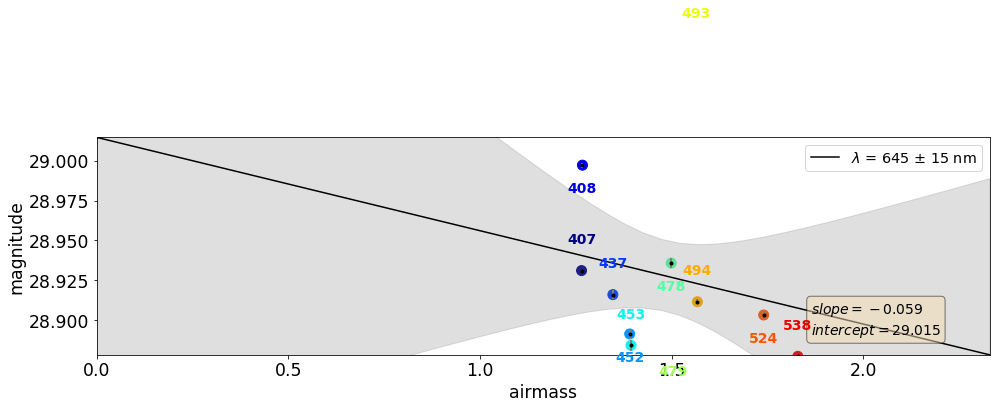

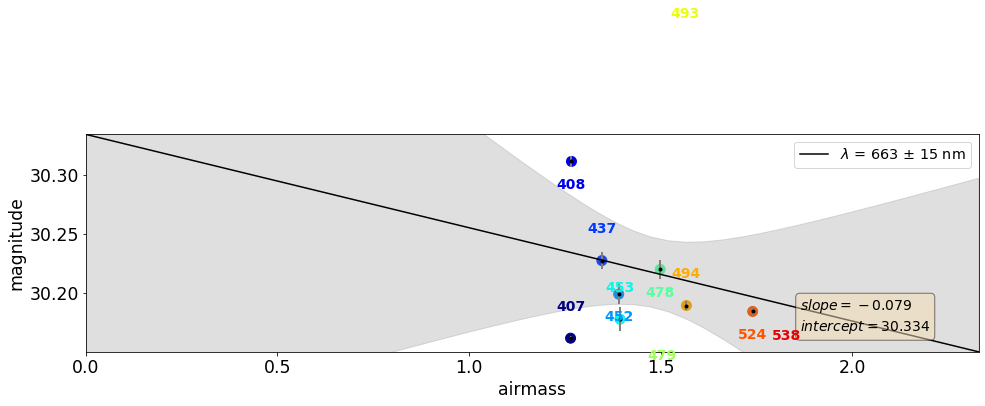

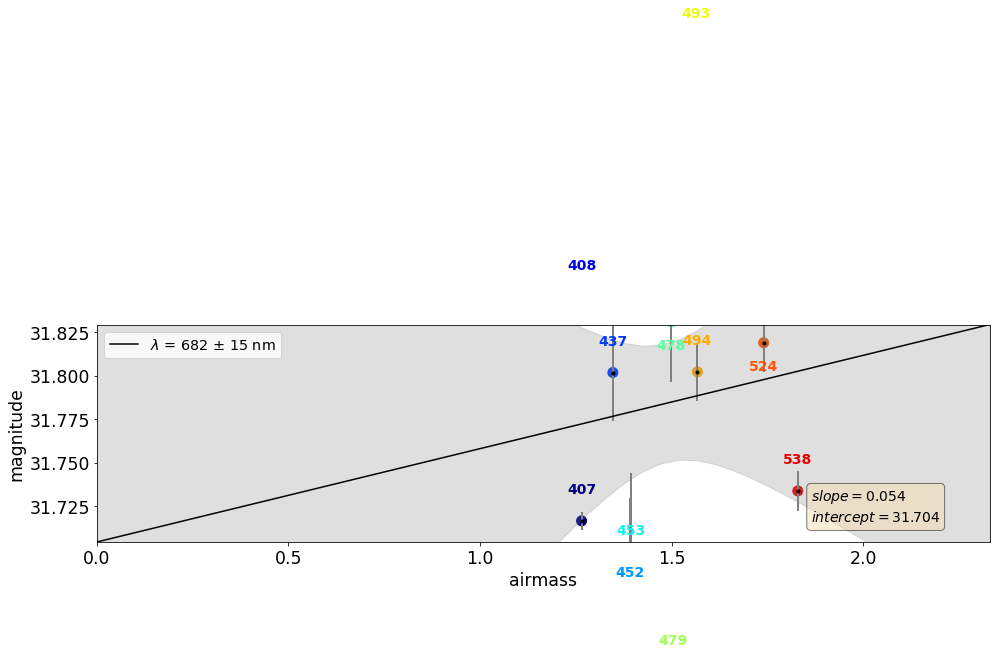

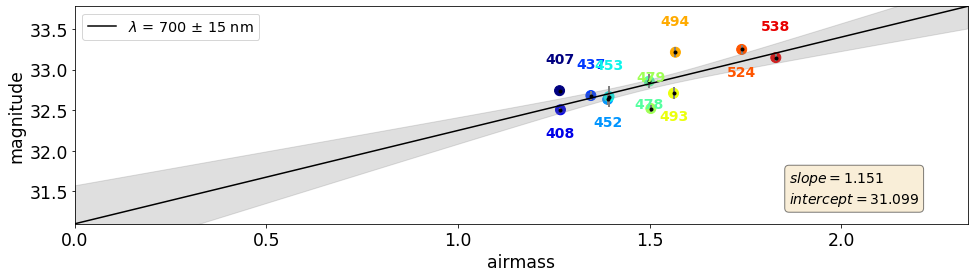

In [106]:
for wl0 in all_wl_center:
    airmasses,numbers,fluxes,efluxes,mags,emags = ComputeOneBouguerLine(infos,all_spectra,wlcenter=wl0,wlbinwidth=WLBINWIDTH)
    intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl0,wl_halfbinwidth,FLAG_PLOT=True,xlabel="airmass",ylabel="magnitude")   

## All Bouguer lines from integrated measured flux

Text(0.5, 1.0, 'Bouguer lines : measured magnitude vs airmass, $\\Delta \\lambda$=30.0nm, 2022-06-30,AUXTEL/Rubin Obs')

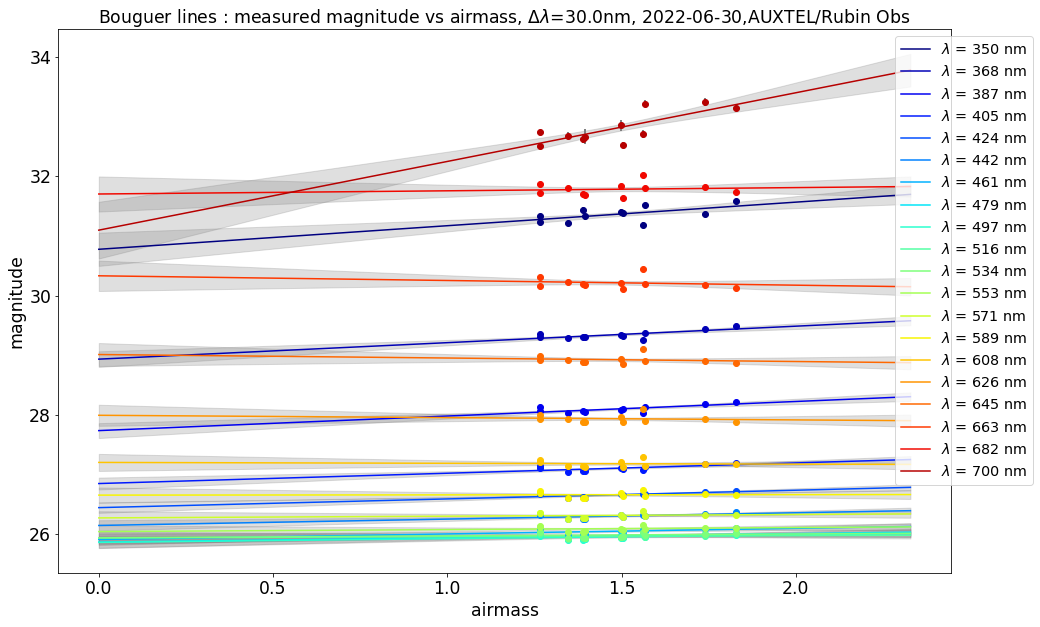

In [107]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)

NWL = len(all_wl_center)
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

idx=0
for wl0 in all_wl_center:
    airmasses,number,fluxes,efluxes,mags,emags = ComputeOneBouguerLine(infos,all_spectra,wlcenter=wl0,wlbinwidth=WLBINWIDTH)
    intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,number,wl0,wl_halfbinwidth,FLAG_PLOT=False,xlabel="airmass",ylabel="magnitude")
    
    ax.errorbar(airmasses,mags, yerr=emags, xerr=None, fmt='o',color=all_colors[idx],ecolor="grey", elinewidth=2, capsize=.01)
    label = f"$\lambda$ = {wl0:.0f} nm"
    ax.plot(x_fit,y_fit,'-',color=all_colors[idx],label=label)
    ax.fill_between(x_fit,y_fit_up , y_fit_dw , alpha=.25, color="gray")
   
    idx+=1
    
ax.legend(loc="upper right",bbox_to_anchor=(1.1,1))    
ax.set_xlabel("airmass")
ax.set_ylabel("magnitude")  
title = f"Bouguer lines : measured magnitude vs airmass, $\Delta \lambda$={wl_binwidth}nm, {DATE},{SITE}"
ax.set_title(title)

## All Bouguer lines from measured integrated flux - integrated SED

Text(0.5, 1.0, 'Bouguer lines : measured magnitude - sed mag vs airmass, $\\Delta \\lambda$=30.0nm, 2022-06-30,AUXTEL/Rubin Obs')

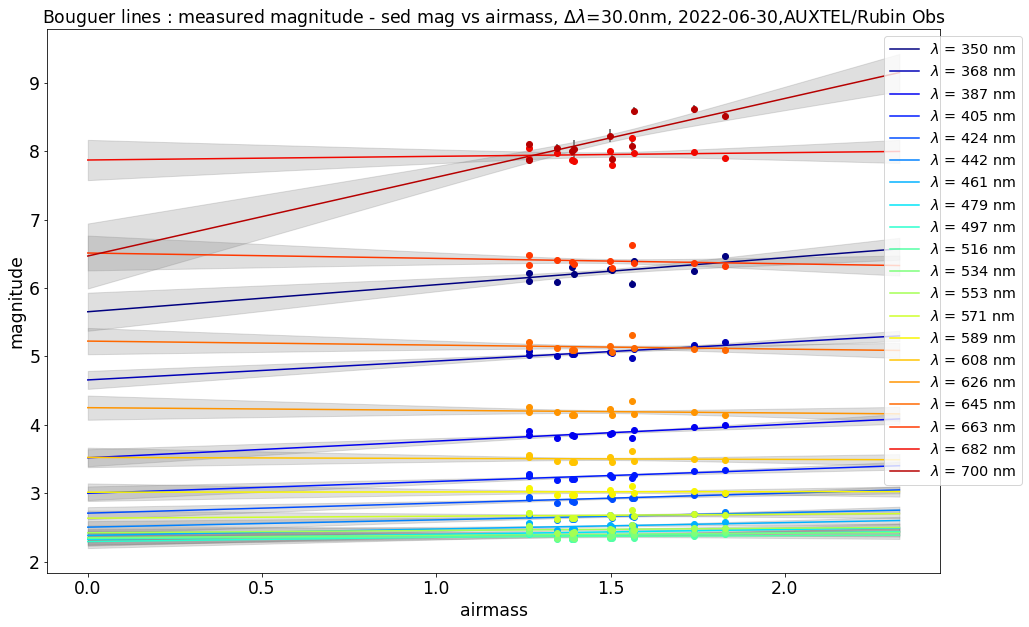

In [108]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)

NWL = len(all_wl_center)
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

idx=0
for wl0 in all_wl_center:
    sed_integ_fl,sed_integ_mag, sed_wl_bin,sed_fl_bin = IntegSEDinBin(sed_w,sed_f,wl0,wlbinwidth=WLBINWIDTH)
    airmasses,numbers,fluxes,efluxes,mags,emags = ComputeOneBouguerLine(infos,all_spectra,wlcenter=wl0,wlbinwidth=WLBINWIDTH)
    intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl0,wl_halfbinwidth,FLAG_PLOT=False,xlabel="airmass",ylabel="magnitude")
    
    ax.errorbar(airmasses,mags-sed_integ_mag, yerr=emags, xerr=None, fmt='o',color=all_colors[idx],ecolor="grey", elinewidth=2, capsize=.01)
    label = f"$\lambda$ = {wl0:.0f} nm"
    ax.plot(x_fit,y_fit-sed_integ_mag,'-',color=all_colors[idx],label=label)
    ax.fill_between(x_fit,y_fit_up-sed_integ_mag , y_fit_dw-sed_integ_mag , alpha=.25, color="gray")
    idx+=1
    
ax.legend(loc="upper right",bbox_to_anchor=(1.1,1))    
ax.set_xlabel("airmass")
ax.set_ylabel("magnitude")  
title = f"Bouguer lines : measured magnitude - sed mag vs airmass, $\Delta \lambda$={wl_binwidth}nm, {DATE},{SITE}"
ax.set_title(title)

In [109]:
#correction_area = 1.06/1.13

In [110]:
print("correction_area=",correction_area)

correction_area= 0.9380530973451329


In [111]:
all_wl_center = np.linspace(WLMINSEL,WLMAXSEL,NPOINTSSAVE)  

In [112]:
idx=0
N=len(all_wl_center)
transm = np.zeros(N)
transm0 = np.zeros(N)
etransm = np.zeros(N)
etransm0 = np.zeros(N)
idx=0
for wl0 in all_wl_center:
    sed_integ_fl,sed_integ_mag, sed_wl_bin,sed_fl_bin = IntegSEDinBin(WL_SED,fcn_sed(WL_SED),wl0,wlbinwidth=WLBINWIDTH)
    airmasses,numbers,fluxes,efluxes,mags,emags = ComputeOneBouguerLine(infos,all_spectra,wlcenter=wl0,wlbinwidth=WLBINWIDTH)
    intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl0,wl_halfbinwidth,FLAG_PLOT=False,xlabel="airmass",ylabel="magnitude")
    m = (y_fit-sed_integ_mag)[0]
    m0 = y_fit[0]
    em = sigmaf[0]
    transm[idx]=np.power(10,-m/2.5)/correction_area
    transm0[idx]=np.power(10,-m0/2.5)/correction_area
    etransm[idx]=em*transm[idx]/correction_area
    etransm0[idx]=em*transm0[idx]/correction_area
    idx+=1

(350.0, 700.0)

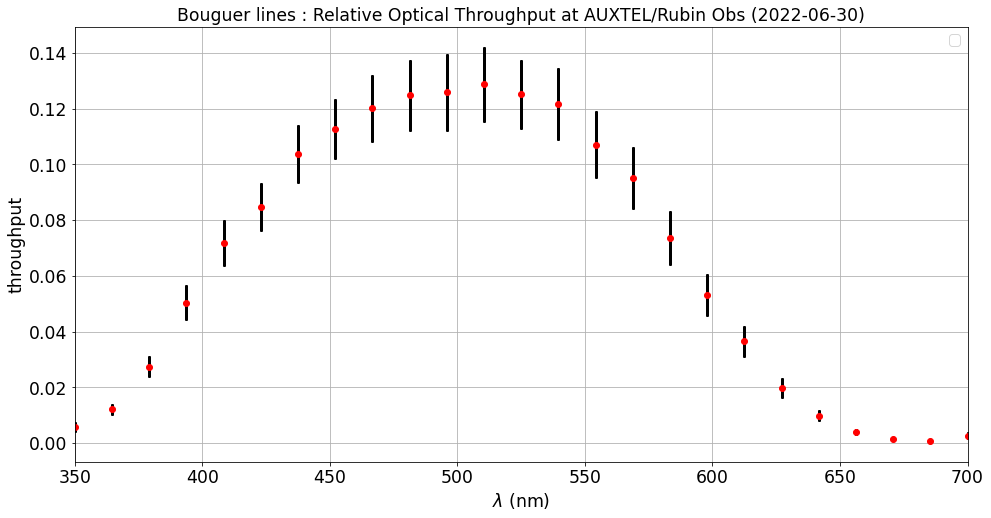

In [113]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)
X=all_wl_center
Y=transm
EY= etransm
ax.errorbar(X,Y, yerr=EY, xerr=None, fmt='o',color="r",ecolor="k", elinewidth=3, capsize=1)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Bouguer lines : Relative Optical Throughput at {SITE} ({DATE})"
ax.set_title(title)
ax.grid()
ax.legend()
ax.set_xlim(WLMINSEL,WLMAXSEL)
        

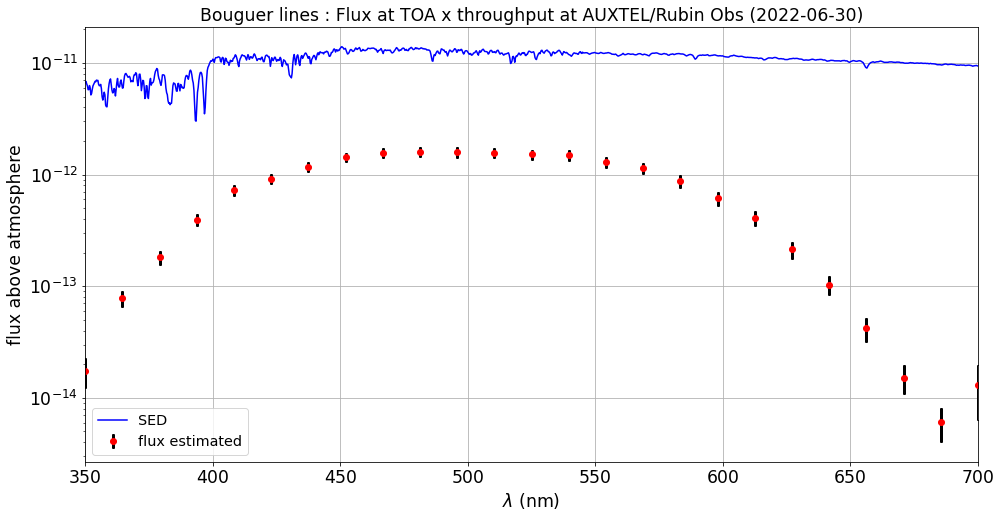

In [114]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)
X=all_wl_center
Y=transm0/wl_binwidth
EY= etransm0/wl_binwidth
ax.plot(sed_w,sed_f,'b-',label="SED")
ax.errorbar(X,Y, yerr=EY, xerr=None, fmt='o',color="r",ecolor="k", elinewidth=3, capsize=1,label="flux estimated")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux above atmosphere")
title=f"Bouguer lines : Flux at TOA x throughput at {SITE} ({DATE})"
ax.set_title(title)
ax.grid()
ax.legend()
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_yscale('log')

# Save throuput and fluxes

In [115]:
dfout = pd.DataFrame()

In [116]:
dfout["wavelength"]=all_wl_center
dfout["throu"]=transm
dfout["errthrou"]=etransm
dfout["sedtoa"]=transm0/wl_binwidth
dfout["errsedtoa"]=etransm0/wl_binwidth

In [117]:
outputfile_linearfit

'MLfit_bouguer_linearfit-20220630-BG40~holo4_003-config_DECONVOLUTION_PSF2D_out.csv'

In [118]:
# Save CSV file
dfout.to_csv(outputfile_linearfit) 